# Compound Flooding Analysis 

**Objective:** Quantify the relationship between river discharge and offshore water level extremes at the Volta River Estuary to assess compound flooding potential.

**Study Area:**
- Volta River Estuary, Ghana
- Estuary bounds: lat [5.73, 5.83]°, lon [0.64, 0.75]°
- Context bounds for maps: lat [3, 9]°, lon [−3, 3]°
- Reference points: at the mouth river (0.667E  5.77N) and at the Volta Lake (0.087E, 6.267N)

**Datasets:**
- **GloFAS v4.0**: Daily river discharge in the last 24h (`dis24`), units m³/s, 2010–2021.
- **JRC Maximum Daily Global Open Ocean Water Level**: Offshore daily maximum WL, units 10⁻⁴ m, 1959–2021.

In [1]:
# --- Reproducibility & environment check ---
import sys, platform, importlib
def check(modname):
    try:
        m = importlib.import_module(modname)
        v = getattr(m, "__version__", "installed")
        print(f"{modname:<10} {v}")
    except ImportError:
        print(f"{modname:<10} NOT INSTALLED")

print("Interpreter:", sys.executable)
print("Python     :", sys.version.split()[0])
print("Platform   :", platform.platform())
for name in ["numpy","pandas","xarray","matplotlib","cartopy","netCDF4","cdsapi","dask"]:
    check(name)

Interpreter: c:\Users\aless\Desktop\tesi\SoC_master_thesis_git\.venv\Scripts\python.exe
Python     : 3.13.4
Platform   : Windows-11-10.0.26100-SP0
numpy      2.3.3
pandas     2.3.2
xarray     2025.9.0
matplotlib 3.10.6
cartopy    0.25.0
netCDF4    1.7.2
cdsapi     installed
dask       2025.9.0


# Import libraries and useful functions

In [2]:
# Standard library
import os, calendar, glob, hashlib, sys, math
import calendar
import locale

locale.setlocale(locale.LC_TIME, "C")  # C locale = English
months = list(calendar.month_name)[1:]

from pathlib import Path
from typing import Dict, List, Tuple, Optional
from requests import HTTPError
from urllib.parse import urljoin, urlparse
from concurrent.futures import ThreadPoolExecutor, as_completed
import requests
import re
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

# Scientific computing
import numpy as np
import pandas as pd
import xarray as xr
from netCDF4 import Dataset

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Geospatial
try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    from matplotlib.patches import Rectangle
    HAS_CARTOPY = True
except Exception:
    HAS_CARTOPY = False

# cds
try:
    import cdsapi
    HAS_CDS = True
except Exception:
    HAS_CDS = False

In [3]:
## Define useful functions ##

# Month names used for x-axis labels
month_names = [m for m in calendar.month_name[1:]]  # ['Jan', 'Feb', ..., 'Dec']

def to_datetime64_from_cftime(tcoord):
    """Convert cftime/CFTimeIndex to numpy datetime64[ns] (YYYY-MM-DD)."""
    return pd.to_datetime([f"{t.year:04d}-{t.month:02d}-{t.day:02d}" for t in tcoord.values])

def year_ticks_for(da_with_time):
    """
    Build yearly ticks/labels from a DataArray with a 'time' coord.
    Returns (ticks, labels) and includes the final +1 year for the right edge.
    """
    years = np.unique(da_with_time['time.year'].values)
    ticks  = [pd.Timestamp(f"{y}-01-01") for y in years] + [pd.Timestamp(f"{years[-1]+1}-01-01")]
    labels = list(years) + [int(years[-1] + 1)]
    return ticks, labels

def month_ticks_for(reference_year: int, abbrev: bool = False):
    """
    Monthly ticks/labels anchored to 'reference_year'.
    Set abbrev=True if you ever want 'Jan, Feb, ...' instead.
    """
    ticks  = pd.date_range(f"{reference_year}-01-01", periods=12, freq="MS")
    labels = [m[:3] for m in calendar.month_name[1:]] if abbrev else list(calendar.month_name[1:])
    return ticks, labels

def detrend_dim(da, dim="time", deg=1, baseline=None, return_trend=False, skipna=True):
    """
    Polynomial detrend along `dim` using xarray's native datetime handling.
    Optionally fit on a `baseline=(start, end)` window, apply to full series.
    """
    da_fit = da.sel({dim: slice(*baseline)}) if baseline else da
    p = da_fit.polyfit(dim=dim, deg=deg, skipna=skipna)
    fit = xr.polyval(da[dim], p.polyfit_coefficients).astype(da.dtype)
    detr = (da - fit).assign_attrs(da.attrs)
    detr.name = (da.name or "var") + "_detrended"
    if return_trend:
        fit.name = (da.name or "var") + "_trend"
        return detr, fit
    return detr

def anom(xarr, baseline=('2010-01-01','2021-12-31')):
    base = xarr.sel(time=slice(*baseline)) if baseline else xarr
    clim = base.groupby('time.month').mean('time')
    ano  = xarr.groupby('time.month') - clim
    return ano, clim

def anomd(xarr, baseline=('2010-01-01','2021-12-31'), deg=1):
    x_det, trend = detrend_dim(xarr, dim='time', deg=deg, baseline=baseline, return_trend=True)
    base_det = x_det.sel(time=slice(*baseline)) if baseline else x_det
    clim_d = base_det.groupby('time.month').mean('time')
    ano_d  = x_det.groupby('time.month') - clim_d
    return ano_d, clim_d, trend

# Study Area

In [4]:
# Define bounds for the Volta River Estuary Area
lat_min, lat_max = 5.73, 5.83
lon_min, lon_max = 0.64, 0.75

# Full map bounds
full_lat_min, full_lat_max = 3, 9
full_lon_min, full_lon_max = -3, 3

# Specific points
lon_estuary, lat_estuary = 0.667, 5.77 # these coordinates are chosen at the estuary, near Ada Foah
lon_lake, lat_lake = 0.087, 6.267 # these are the coordinates of the Volta River just downstream of Volta Lake, close to Akosombo.


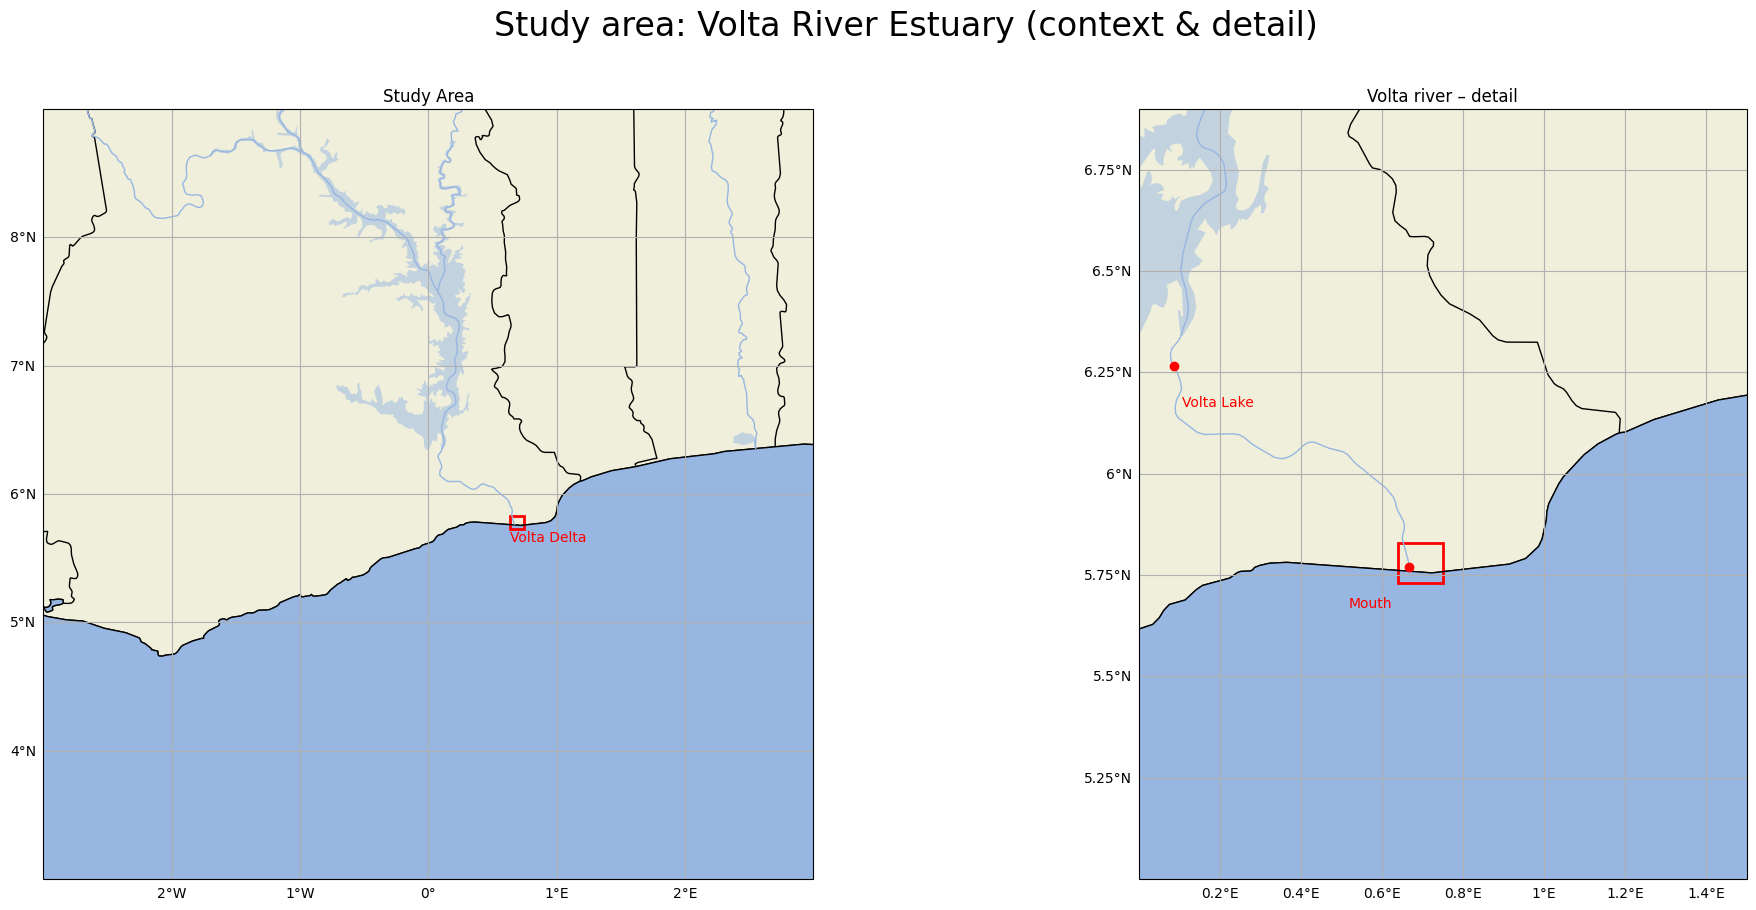

In [5]:
# Overview map + zoom
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 10), subplot_kw={"projection": ccrs.PlateCarree()})
fig.suptitle("Study area: Volta River Estuary (context & detail)", fontsize=24)

    # Context
ax0 = ax[0]
ax0.set_extent([full_lon_min, full_lon_max, full_lat_min, full_lat_max])
ax0.coastlines("10m")
ax0.add_feature(cfeature.BORDERS, linewidth=1)
ax0.add_feature(cfeature.LAND, edgecolor='black')
ax0.add_feature(cfeature.RIVERS)
ax0.add_feature(cfeature.LAKES, alpha=0.5)
ax0.add_feature(cfeature.OCEAN)
gl0 = ax0.gridlines(draw_labels=True)
gl0.top_labels = False; gl0.right_labels = False
gl0.xformatter = LONGITUDE_FORMATTER; gl0.yformatter = LATITUDE_FORMATTER
ax0.set_title("Study Area")
rect = Rectangle((lon_min, lat_min), lon_max-lon_min, lat_max-lat_min,
                     linewidth=2, edgecolor='red', facecolor='none', transform=ccrs.PlateCarree())
ax0.add_patch(rect)
ax0.text(lon_min, lat_max-0.2, "Volta Delta", color="red", transform=ccrs.PlateCarree())

# Detail
ax1 = ax[1]
ax1.set_extent([0, 1.5, 5, 6.9])
ax1.coastlines("10m")
ax1.add_feature(cfeature.BORDERS, linewidth=1)
ax1.add_feature(cfeature.LAND, edgecolor='black')
ax1.add_feature(cfeature.RIVERS)
ax1.add_feature(cfeature.LAKES, alpha=0.5)
ax1.add_feature(cfeature.OCEAN)
gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels = False; gl1.right_labels = False
gl1.xformatter = LONGITUDE_FORMATTER; gl1.yformatter = LATITUDE_FORMATTER
ax1.set_title("Volta river – detail")
rect2 = Rectangle((lon_min, lat_min), lon_max-lon_min, lat_max-lat_min,
                      linewidth=2, edgecolor='red', facecolor='none', transform=ccrs.PlateCarree())
ax1.add_patch(rect2)

# Points
ax1.plot([lon_estuary, lon_lake], [lat_estuary, lat_lake], 'o', color='red', transform=ccrs.PlateCarree())
ax1.text(lon_estuary-0.15, lat_estuary-0.1, "Mouth", color='red', transform=ccrs.PlateCarree())
ax1.text(lon_lake+0.02,  lat_lake-0.1,   "Volta Lake", color='red', transform=ccrs.PlateCarree())
plt.show()


For further analysis, it will be take into account a single point, located at the Volta River Mouth (5.77°N e 0.667°E), and an additional point further upstream, at Volta Lake (6.50°N, 0.117°E).


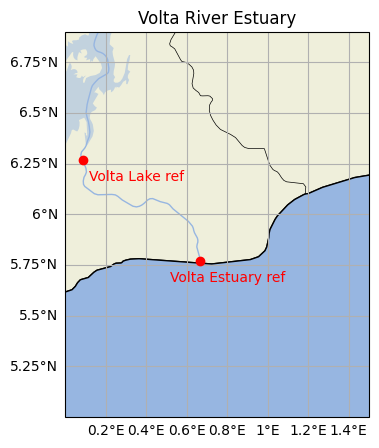

In [6]:
# Base map with points
fig = plt.figure(figsize=(6,5))
axb = plt.axes(projection=ccrs.PlateCarree())
axb.set_extent([0, 1.5, 5, 6.9])
axb.coastlines("10m")
axb.add_feature(cfeature.LAND, edgecolor='black')
axb.add_feature(cfeature.BORDERS, linewidth=0.5)
axb.add_feature(cfeature.RIVERS)
axb.add_feature(cfeature.LAKES, alpha=0.5)
axb.add_feature(cfeature.OCEAN)
gl = axb.gridlines(draw_labels=True)
gl.right_labels = False; gl.top_labels = False
axb.plot([lon_estuary, lon_lake], [lat_estuary, lat_lake], 'o', color='red', transform=ccrs.PlateCarree())
axb.text(lon_estuary-0.15, lat_estuary-0.1, 'Volta Estuary ref', color='red', transform=ccrs.PlateCarree())
axb.text(lon_lake+0.03,    lat_lake-0.1,    'Volta Lake ref',   color='red', transform=ccrs.PlateCarree())
axb.set_title("Volta River Estuary")
plt.show()

# Load and preprocess data

In [7]:
# Data locations – local paths
GLOFAS_DIR = r"C:/Users/aless/Desktop/tesi/data/glofas_keta"
JRC_DIR    = r"C:/Users/aless/Desktop/tesi/data/globalDailyMaxWaterLevel/VER2024-05-03"

In [8]:
# Periods
BASELINE = ("2010-01-01", "2021-12-31")
GLOFAS_YEARS = list(range(2010, 2022))    # inclusive
JRC_PERIOD   = ("2010-01-01", "2021-12-31")

# GloFAS area ([N, W, S, E])
GLOFAS_AREA = [9, -3, 0, 3]

# Nodata for GloFAS
GLOFAS_NODATA = 9999.0

## GloFAS data
**GloFAS v4.0 (cems-glofas-historical)**
- **Source:** CEMS Early Warning Data Store (EWDS), Copernicus (https://ewds.climate.copernicus.eu/datasets/cems-glofas-historical?tab=overview).
- **Time span used here:** 2010–2021 (inclusive), **daily** discharge in last 24h.
- **Variable / units:** `dis24` (river discharge in the last 24 h), m³/s.
- **Spatial subset:** [0–9°N, 3°W–3°E] (area = [N, W, S, E]).
- **Acquisition:** API request kept in code for reproducibility; `dry_run=True` prevents re-downloads (files were already retrieved).
- **Preprocessing:** Per-year NetCDF files concatenated along `time`, sorted by time, duplicates handled; nearest grid cell to (5.77°N, 0.667°E) and (6.50°N, 0.117°E).


In [9]:
# Working directory and configuration
years: List[int] = list(range(2010, 2022)) # 2010..2021 inclusive
area = [9, -3, 0, 3] # [North, West, South, East] => 0–9°N, 3°W–3°E
dry_run = False       # set to False if you want to download
os.makedirs(GLOFAS_DIR, exist_ok=True)

def build_glofas_request(year: int,
                         data_format: str = "grib2",
                         system_version: str = "version_4_0") -> Dict:
    return {
        "system_version": [system_version],
        "hydrological_model": ["lisflood"],
        "product_type": ["consolidated"],
        "variable": ["river_discharge_in_the_last_24_hours"],
        "hyear": [f"{year}"],
        "hmonth": [f"{m:02d}" for m in range(1, 13)],
        "hday": [f"{d:02d}" for d in range(1, 32)],
        "area": area,                       # [N, W, S, E]
        "data_format": data_format,         # EWDS shows grib2 for this dataset
        "download_format": "unarchived",    # optional but fine
    }

def _sha256(path: str) -> str:
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(1 << 20), b""):
            h.update(chunk)
    return h.hexdigest()

def request_glofas_year(year: int, force: bool = False, min_ok_size: int = 1_000_000) -> Dict:
    """
    Download one year unless an existing file looks good.
    - force=True     -> always re-download
    - min_ok_size    -> files smaller than this are treated as incomplete
    """
    name = f"glofas_dis24_{year}.grib2"
    path = os.path.join(GLOFAS_DIR, name)
    tmp = path + ".part"

    existed = os.path.exists(path)
    size_before = os.path.getsize(path) if existed else 0

    if existed and size_before >= min_ok_size and not force:
        print(f"✔ {name} present ({size_before/1e6:.1f} MB) — skipping.")
        return {"year": year, "action": "skipped", "path": path, "size": size_before}

    req = build_glofas_request(year)
    if dry_run:
        print(f"[DRY RUN] Would {'re-' if existed else ''}download {name} with request = {req}")
        return {"year": year, "action": "dry_run", "path": path}

    # Remove any stale partial file before starting
    if os.path.exists(tmp):
        try:
            os.remove(tmp)
        except OSError:
            pass

    c = cdsapi.Client()
    print(f"⬇ {'Re-' if existed else ''}downloading {name} ...")
    try:
        c.retrieve("cems-glofas-historical", req, tmp)
        os.replace(tmp, path)  # atomic move
    except HTTPError as e:
        try:
            print("Server says:", e.response.text[:2000])
        except Exception:
            pass
        # Best effort cleanup of partial
        if os.path.exists(tmp):
            try:
                os.remove(tmp)
            except OSError:
                pass
        raise

    size_after = os.path.getsize(path)
    info = {
        "year": year,
        "action": "downloaded" if not existed else "re-downloaded",
        "path": path,
        "size": size_after,
        "hash": _sha256(path),
    }
    print(f"✔ {name} saved ({size_after/1e6:.1f} MB)")
    return info

# Full run
summary = [request_glofas_year(y) for y in years] # normal run
# request_glofas_year(2015, force=True)                    # force only a year
# summary = [request_glofas_year(y, min_ok_size=5_000_000) for y in years]  # stricter size check
print("Done.")


✔ glofas_dis24_2010.grib2 present (10.0 MB) — skipping.
✔ glofas_dis24_2011.grib2 present (10.0 MB) — skipping.
✔ glofas_dis24_2012.grib2 present (10.1 MB) — skipping.
✔ glofas_dis24_2013.grib2 present (10.0 MB) — skipping.
✔ glofas_dis24_2014.grib2 present (10.0 MB) — skipping.
✔ glofas_dis24_2015.grib2 present (11.1 MB) — skipping.
✔ glofas_dis24_2016.grib2 present (10.1 MB) — skipping.
✔ glofas_dis24_2017.grib2 present (10.0 MB) — skipping.
✔ glofas_dis24_2018.grib2 present (10.0 MB) — skipping.
✔ glofas_dis24_2019.grib2 present (10.0 MB) — skipping.
✔ glofas_dis24_2020.grib2 present (10.1 MB) — skipping.
✔ glofas_dis24_2021.grib2 present (10.0 MB) — skipping.
Done.


In [10]:
# Read local files and concatenate (no network)
files_glofas = sorted(glob.glob(os.path.join(GLOFAS_DIR, "*.nc")))
if not files_glofas:
    raise FileNotFoundError(f"No .nc files found in {GLOFAS_DIR}. Put your existing files there.")

# Open and combine files
datasets = [xr.open_dataset(p) for p in files_glofas]
glofas_keta = xr.concat(datasets, dim="time")  
glofas_keta

<xarray.Dataset> Size: 252MB
Dimensions:    (time: 4383, latitude: 120, longitude: 120)
Coordinates:
  * latitude   (latitude) float32 480B 3.025 3.075 3.125 ... 8.875 8.925 8.975
  * longitude  (longitude) float32 480B -2.975 -2.925 -2.875 ... 2.925 2.975
  * time       (time) datetime64[ns] 35kB 2010-02-01 2010-02-02 ... 2021-12-31
Data variables:
    dis24      (time, latitude, longitude) float32 252MB 9.999e+03 ... 0.0

In [11]:
# Checking on and sorting the 'time' variable

# Get a DatetimeIndex for convenience
t = getattr(glofas_keta.indexes, 'time', pd.DatetimeIndex(glofas_keta['time'].values))
print("Count:", t.size)
print("First :", t[0])
print("Last  :", t[-1])

# Sortedness / monotonicity
print("Monotonic increasing:", t.is_monotonic_increasing)
print("Has duplicates      :", t.has_duplicates)

# Peek at the edges
print("Head:", t[:5].tolist())
print("Tail:", t[-5:].tolist())

# Frequency / regularity
print("Inferred frequency  :", t.inferred_freq)  # None => irregular

# Show where ordering is broken (if any)
bad_order_idx = np.where(t[1:] < t[:-1])[0]
print("Out-of-order indices:", bad_order_idx[:10], "(showing up to 10)")

# Gap summary (how many times each delta occurs)
diffs = pd.Series(t[1:] - t[:-1])
print("Most common gaps:\n", diffs.value_counts().head(5))
print("Unique gaps:", pd.unique(diffs))

Count: 4383
First : 2010-02-01 00:00:00
Last  : 2021-12-31 00:00:00
Monotonic increasing: False
Has duplicates      : False
Head: [Timestamp('2010-02-01 00:00:00'), Timestamp('2010-02-02 00:00:00'), Timestamp('2010-02-03 00:00:00'), Timestamp('2010-02-04 00:00:00'), Timestamp('2010-02-05 00:00:00')]
Tail: [Timestamp('2021-12-27 00:00:00'), Timestamp('2021-12-28 00:00:00'), Timestamp('2021-12-29 00:00:00'), Timestamp('2021-12-30 00:00:00'), Timestamp('2021-12-31 00:00:00')]
Inferred frequency  : None
Out-of-order indices: [ 147  512  878 1243 1608 1973 2339 2704 3069 3434] (showing up to 10)
Most common gaps:
 1 days       4251
31 days        48
32 days        47
63 days        12
-333 days       9
Name: count, dtype: int64
Unique gaps: [    86400000000000   2764800000000000   5443200000000000
 -28771200000000000   2505600000000000   2678400000000000
 -28857600000000000   2592000000000000]


In [12]:
# Show the exact out-of-order transitions (with context)
t = glofas_keta.get_index('time')
bad_idx = np.where(t[1:] < t[:-1])[0]  # indices where next < prev
print("Out-of-order count:", bad_idx.size)

# Show a little neighborhood around each break
for i in bad_idx:
    lo = max(0, i-2)
    hi = min(len(t), i+3)
    print(f"\nBreak at i={i} (t[i] -> t[i+1]):")
    print(pd.Series(t[lo:hi]).to_string())

Out-of-order count: 12

Break at i=147 (t[i] -> t[i+1]):
0   2010-11-28
1   2010-11-29
2   2010-11-30
3   2010-01-01
4   2010-01-02

Break at i=512 (t[i] -> t[i+1]):
0   2011-11-28
1   2011-11-29
2   2011-11-30
3   2011-01-01
4   2011-01-02

Break at i=878 (t[i] -> t[i+1]):
0   2012-11-28
1   2012-11-29
2   2012-11-30
3   2012-01-01
4   2012-01-02

Break at i=1243 (t[i] -> t[i+1]):
0   2013-11-28
1   2013-11-29
2   2013-11-30
3   2013-01-01
4   2013-01-02

Break at i=1608 (t[i] -> t[i+1]):
0   2014-11-28
1   2014-11-29
2   2014-11-30
3   2014-01-01
4   2014-01-02

Break at i=1973 (t[i] -> t[i+1]):
0   2015-11-28
1   2015-11-29
2   2015-11-30
3   2015-01-01
4   2015-01-02

Break at i=2339 (t[i] -> t[i+1]):
0   2016-11-28
1   2016-11-29
2   2016-11-30
3   2016-01-01
4   2016-01-02

Break at i=2704 (t[i] -> t[i+1]):
0   2017-11-28
1   2017-11-29
2   2017-11-30
3   2017-01-01
4   2017-01-02

Break at i=3069 (t[i] -> t[i+1]):
0   2018-11-28
1   2018-11-29
2   2018-11-30
3   2018-01-01
4   2

In [13]:
# Sort by time and verify
glofas_sorted = glofas_keta.sortby('time')
ti = glofas_sorted.get_index('time')

print("Monotonic after sort:", ti.is_monotonic_increasing)
print("Start/End after sort:", ti[0], ti[-1])
print("Inferred freq after sort:", ti.inferred_freq)  # still None if gaps remain

Monotonic after sort: True
Start/End after sort: 2010-01-01 00:00:00 2021-12-31 00:00:00
Inferred freq after sort: D


In [14]:
# Identify and list missing dates (daily grid)
full = pd.date_range(t.min(), t.max(), freq='D')
have = glofas_sorted.time.to_index()
missing = full.difference(have)
print("Missing days:", len(missing))
print("First 20 missing:\n", pd.Series(missing[:20]))

# Summarize missing by year
miss_df = pd.DataFrame({"date": missing})
miss_df["year"] = miss_df["date"].dt.year
print(miss_df["year"].value_counts().sort_index())

Missing days: 0
First 20 missing:
 Series([], dtype: datetime64[ns])
Series([], Name: count, dtype: int64)


In [15]:
# Extract raw (daily) values to the point closest to the two points
rd_estuary = glofas_sorted['dis24'].sel(latitude = lat_estuary, longitude = lon_estuary, method='nearest')
rd_lake = glofas_sorted['dis24'].sel(latitude = lat_lake, longitude = lon_lake, method='nearest')

# confirm where we actually landed
sel_estuary_lat = float(rd_estuary.latitude.values)
sel_estuary_lon = float(rd_estuary.longitude.values)
sel_lake_lat  = float(rd_lake.latitude.values)
sel_lake_lon  = float(rd_lake.longitude.values)

print("Estuary grid cell:",  sel_estuary_lat, sel_estuary_lon)
print("Lake grid cell:",   sel_lake_lat,  sel_lake_lon)

Estuary grid cell: 5.775000095367432 0.675000011920929
Lake grid cell: 6.275000095367432 0.07500000298023224


## Water Level

**JRC Maximum Daily Global Open Ocean Water Level (VER2024-05-03)**
- **Source:** JRC “Maximum Daily Global Open Ocean Water Level” reanalysis (https://data.jrc.ec.europa.eu/dataset/1c7c05e0-f501-4de1-91c4-0c172ba967fd).
- **Time span available:** 1959–2021; **subset used:** 2010–2021.
- **Variable / units:** `waterLevelreanalysis` in units of \(10^{-4}\) m. **Converted to meters** here by multiplying by \(1\times10^{-4}\).
- **Spatial subset:** points within [3–9°N, 3°W–3°E]; nearest point to (5.77°N, 0.667°E) used for offshore signal.
- **Preprocessing:** Files are supplied as 634 latitude strips; strips were concatenated to form a single dataset, then spatially subset to [3–9°N, 3°W–3°E]. Time coordinate standardized to `time`; files filtered to the study region, concatenated across points, then converted to meters.

In [16]:
# Download Water Level data if not present in the local directory
"""
Download all NetCDF (.nc) files from the JRC LISCOAST 'globalDailyMaxWaterLevel'
FTP-like directory. You can target:
  - the latest published version (VERSION="latest"),
  - all versions (VERSION="all"),
  - or a specific version folder (e.g., VERSION="VER2024-05-03").

Features:
  • Parallel downloads with polite retry logic
  • Skips files already present (compares size via HTTP HEAD)
  • Dry-run mode to preview what would be downloaded
  • Atomic writes via .part + os.replace to avoid half files
"""

# ================== Configuration ==================
BASE_URL   = "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/LISCOAST/globalDailyMaxWaterLevel/"
OUT_DIR    = r"C:/Users/aless/Desktop/tesi/data/globalDailyMaxWaterLevel"  # destination folder
VERSION    = "latest"   # "latest" | "all" | "VER2024-05-03" (or any listed version)
ONLY_EXT   = ".nc"      # download only NetCDF files
MAX_WORKERS = 4         # number of parallel downloads (keep modest to be polite)
DRY_RUN    = True       # True = show actions without downloading | False = if you want to download the files
# ===================================================

# Ensure destination folder exists
os.makedirs(OUT_DIR, exist_ok=True)


def make_session() -> requests.Session:
    """Create a requests.Session with retries and a custom User-Agent."""
    s = requests.Session()
    s.headers.update({"User-Agent": "liscoast-downloader/1.0"})
    # Retry on common transient HTTP errors (429/5xx), with exponential backoff
    retries = Retry(
        total=5,
        backoff_factor=0.5,
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods=["HEAD", "GET"],
    )
    adapter = HTTPAdapter(max_retries=retries)
    s.mount("https://", adapter)
    s.mount("http://", adapter)
    return s


def get(session: requests.Session, url: str) -> str:
    """GET a page and return its HTML text. Raises for HTTP errors."""
    r = session.get(url, timeout=60)
    r.raise_for_status()
    return r.text


def head(session: requests.Session, url: str) -> int | None:
    """
    Return the Content-Length (file size in bytes) if the server provides it.
    Fallback to a streamed GET if HEAD is not supported (405).
    """
    r = session.head(url, allow_redirects=True, timeout=60)
    if r.status_code == 405:  # some servers don't implement HEAD
        r = session.get(url, stream=True, timeout=60)
    r.raise_for_status()
    cl = r.headers.get("Content-Length")
    return int(cl) if cl and cl.isdigit() else None


def list_dirs(session: requests.Session, url: str) -> List[str]:
    """
    List version subdirectories like 'VER2024-05-03' from the base index page.
    The index is a simple Apache-style directory listing.
    """
    html = get(session, url)
    # capture strings like href="VER2024-05-03/"
    return sorted(set(re.findall(r'href="(VER\d{4}-\d{2}-\d{2})/', html)))


def list_files(session: requests.Session, url: str, only_ext: str) -> List[Tuple[str, str]]:
    """
    List (name, url) for files in the given version directory that end with only_ext.
    We avoid 'Parent Directory' entries by excluding hrefs that start with '/'.
    """
    html = get(session, url)
    hrefs = re.findall(r'href="([^"/][^"]+)"', html)  # match plain file names
    return [(h, urljoin(url, h)) for h in hrefs if h.lower().endswith(only_ext.lower())]


def pick_latest_version(session: requests.Session) -> str:
    """Pick the lexicographically last version (works because the name contains YYYY-MM-DD)."""
    vers = list_dirs(session, BASE_URL)
    if not vers:
        raise RuntimeError("No versions found in the root directory.")
    # 'VER2024-05-03' sorts correctly by date when we strip the 'VER' prefix
    return sorted(vers, key=lambda v: v.replace("VER", ""))[-1]


def should_skip(local_path: str, remote_size: int | None) -> bool:
    """
    Decide whether to skip downloading a file:
      - If local file doesn't exist -> don't skip
      - If remote_size is unknown -> assume local file is fine and skip
      - Otherwise compare sizes and skip if identical
    """
    if not os.path.exists(local_path):
        return False
    return True if remote_size is None else os.path.getsize(local_path) == remote_size


def download_file(session: requests.Session, url: str, dst: str, remote_size: int | None):
    """
    Download a single file to 'dst'. Writes to a temporary '.part' file and then
    atomically renames it to avoid half-written files on interruptions.
    """
    # Avoid re-downloading existing identical files
    if should_skip(dst, remote_size):
        print(f"✔ {os.path.basename(dst)} present — skip")
        return "skipped"

    # Dry-run mode prints what it *would* do
    if DRY_RUN:
        print(f"[DRY RUN] Would download {os.path.basename(dst)} ({remote_size} bytes)")
        return "dry_run"

    tmp = dst + ".part"
    # Clean up stale partial file if present
    if os.path.exists(tmp):
        try:
            os.remove(tmp)
        except OSError:
            pass

    # Stream the response in chunks so we don't keep the whole file in memory
    with session.get(url, stream=True, timeout=180) as r:
        r.raise_for_status()
        with open(tmp, "wb") as f:
            for chunk in r.iter_content(chunk_size=1 << 20):  # 1 MB chunks
                if chunk:
                    f.write(chunk)

    # Atomic move: ensures we either have the old file or the fully downloaded new file
    os.replace(tmp, dst)
    print(f"⬇ {os.path.basename(dst)} saved ({os.path.getsize(dst)/1e6:.1f} MB)")
    return "downloaded"


def process_version(session: requests.Session, version: str):
    """
    Download all files with the desired extension from one version directory.
    Performs a HEAD first to get sizes for skip logic, then downloads in parallel.
    """
    version_url = urljoin(BASE_URL, version + "/")
    files = list_files(session, version_url, ONLY_EXT)
    if not files:
        print(f"No {ONLY_EXT} files found in {version_url}")
        return

    print(f"[{version}] Found {len(files)} files")
    # Pre-fetch remote sizes for smarter skipping
    sizes = {}
    for name, url in files:
        try:
            sizes[name] = head(session, url)
        except Exception:
            sizes[name] = None  # if size is unknown we still proceed

    # Parallel downloads (keep MAX_WORKERS modest)
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
        futures = [
            ex.submit(download_file, session, url, os.path.join(OUT_DIR, name), sizes.get(name))
            for name, url in files
        ]
        # Ensure exceptions propagate here
        for fut in as_completed(futures):
            fut.result()


def main():
    """Entry point: decide which version(s) to process and start downloading."""
    session = make_session()

    if VERSION == "all":
        # Iterate every version folder under the base URL
        for ver in list_dirs(session, BASE_URL):
            print(f"→ Version: {ver}")
            process_version(session, ver)
    else:
        # Either pick the latest or use the specific version string provided
        ver = pick_latest_version(session) if VERSION == "latest" else VERSION
        print(f"→ Using version: {ver}")
        process_version(session, ver)

    print("Done.")


if __name__ == "__main__":
    main()


→ Using version: VER2024-05-03
[VER2024-05-03] Found 634 files
[DRY RUN] Would download pcvar_hindcast_00000001.nc (48278568 bytes)
[DRY RUN] Would download pcvar_hindcast_00000002.nc (52437942 bytes)
[DRY RUN] Would download pcvar_hindcast_00000003.nc (52390800 bytes)
[DRY RUN] Would download pcvar_hindcast_00000004.nc (52390800 bytes)
[DRY RUN] Would download pcvar_hindcast_00000005.nc (52390800 bytes)
[DRY RUN] Would download pcvar_hindcast_00000006.nc (52343658 bytes)
[DRY RUN] Would download pcvar_hindcast_00000007.nc (52296516 bytes)
[DRY RUN] Would download pcvar_hindcast_00000009.nc (52343658 bytes)
[DRY RUN] Would download pcvar_hindcast_00000012.nc (52437942 bytes)
[DRY RUN] Would download pcvar_hindcast_00000010.nc (52437942 bytes)
[DRY RUN] Would download pcvar_hindcast_00000011.nc (52390800 bytes)
[DRY RUN] Would download pcvar_hindcast_00000008.nc (52296516 bytes)
[DRY RUN] Would download pcvar_hindcast_00000016.nc (52390800 bytes)
[DRY RUN] Would download pcvar_hindcast_

In [17]:
# Import data from working directory
data_dir_w = r"C:/Users/aless/Desktop/tesi/data/globalDailyMaxWaterLevel/VER2024-05-03"
file_jrc = sorted(glob.glob(os.path.join(data_dir_w, "*.nc")))

# Checking for the presence and validity of files in the working directory
valid_files = []
invalid_files = []

for filepath in file_jrc:
    if os.path.isfile(filepath) and filepath.endswith(".nc"):
        try:
            ds = Dataset(filepath)
            ds.close()
            valid_files.append(filepath)
        except:
            invalid_files.append(filepath)
    else:
        invalid_files.append(filepath)
print(f"Valid NetCDF files: {len(valid_files)}")
print(f"Unreadable NetCDF files: {len(invalid_files)}")

if invalid_files:
    print("Examples of invalid files:")
    for f in invalid_files[:5]:
        print(" -", f)

Valid NetCDF files: 634
Unreadable NetCDF files: 0


In [18]:
# Explore data structure
sample_ds = Dataset(valid_files[0])
print("DATASET INFO:")
print(sample_ds)
print("VARIABLES:")
print(sample_ds.variables.keys())

water_var = sample_ds.variables['waterLevelreanalysis'][:]  
print(f"WATER LEVEL shape: {water_var.shape}")
print(f"TIME VARIABLE:", sample_ds['time_1959_2021'])

sample_ds.close()
sample_xr = xr.open_dataset(valid_files[0])
print(sample_xr)
print(sample_xr.coords)
print(sample_xr.dims)
print(sample_xr['waterLevelreanalysis'].attrs)

DATASET INFO:
<class 'netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Institution: European Commission, Directorate-General Joint Research Centre, Disaster Risk Management Unit, Via Enrico Fermi 2749, I-21027-Ispra
    dimensions(sizes): pointsSAT(997), PCR(65), pointsATM(36), time_1959_2021(23011)
    variables(dimensions): float64 AC(pointsSAT), float64 PCRcoef(pointsSAT, PCR), float64 latitudeATM(pointsSAT, pointsATM), float64 latitudeSAT(pointsSAT), float64 longitudeATM(pointsSAT, pointsATM), float64 longitudeSAT(pointsSAT), float64 time_1959_2021(time_1959_2021), int16 waterLevelreanalysis(pointsSAT, time_1959_2021)
    groups: 
VARIABLES:
dict_keys(['AC', 'PCRcoef', 'latitudeATM', 'latitudeSAT', 'longitudeATM', 'longitudeSAT', 'time_1959_2021', 'waterLevelreanalysis'])
WATER LEVEL shape: (997, 23011)
TIME VARIABLE: <class 'netCDF4.Variable'>
float64 time_1959_2021(time_1959_2021)
    units: days since 1950-01-01
unlimited dimensions: time_1959_202

In [19]:
# Open and concatenate datasets
filtered = []
for f in file_jrc:
    ds = xr.open_dataset(f)
    mask = ((ds.longitudeSAT >= full_lon_min) & (ds.longitudeSAT <= full_lon_max) &
            (ds.latitudeSAT  >= full_lat_min) & (ds.latitudeSAT  <= full_lat_max))
    ds = ds.sel(pointsSAT=mask)
    if ds.sizes.get("pointsSAT", 0) > 0:
        filtered.append(ds)
if not filtered:
    raise ValueError("No datasets found within the target region. Check coordinate ranges.")

keta_wl = xr.concat(filtered, dim="pointsSAT", combine_attrs="override")
print("Longitude range:", float(keta_wl.longitudeSAT.min()), "to", float(keta_wl.longitudeSAT.max()))
print("Latitude range:",  float(keta_wl.latitudeSAT.min()),  "to", float(keta_wl.latitudeSAT.max()))
keta_wl

Longitude range: -2.875 to 2.875
Latitude range: 3.125 to 6.375


<xarray.Dataset> Size: 46MB
Dimensions:               (pointsSAT: 249, PCR: 65, pointsATM: 36,
                           time_1959_2021: 23011)
Coordinates:
  * time_1959_2021        (time_1959_2021) datetime64[ns] 184kB 1959-01-01 .....
Dimensions without coordinates: pointsSAT, PCR, pointsATM
Data variables:
    AC                    (pointsSAT) float64 2kB 0.9505 0.9525 ... 0.9446
    PCRcoef               (pointsSAT, PCR) float64 129kB 0.03118 ... -0.0005355
    latitudeATM           (pointsSAT, pointsATM) float64 72kB 3.75 3.5 ... 5.75
    latitudeSAT           (pointsSAT) float64 2kB 3.125 3.375 ... 6.125 6.375
    longitudeATM          (pointsSAT, pointsATM) float64 72kB 356.8 ... 3.5
    longitudeSAT          (pointsSAT) float64 2kB -2.625 -2.625 ... 2.875 2.875
    waterLevelreanalysis  (pointsSAT, time_1959_2021) float64 46MB 390.0 ... ...
Attributes:
    Institution:  European Commission, Directorate-General Joint Research Cen...

In [20]:
# Convert to meters (x 1e-4)
  # 1) convert to meters in place (respect fill if present)
v = keta_wl["waterLevelreanalysis"]
fill = v.encoding.get("_FillValue", v.attrs.get("_FillValue"))
keta_wl["waterLevelreanalysis"] = (v.where(v != fill) if fill is not None else v) * 1e-4
keta_wl["waterLevelreanalysis"].attrs.update({
    **{k: v.attrs.get(k) for k in v.attrs if k != "units"},
    "units": "m",
    "long_name": "daily maximum offshore water level (meters)",
    "note": "converted from 1e-4 m by multiplying by 1e-4"})

  # 2) standardize time coord only if needed
time_name = next((c for c in ["time", "time_1959_2021", "valid_time"] if c in keta_wl.coords), None)
if time_name and time_name != "time":
    keta_wl = keta_wl.rename({time_name: "time"})


In [21]:
# Selection of the ofshore point nearest to the estuary
dist2 = (keta_wl.latitudeSAT - lat_estuary)**2 + (keta_wl.longitudeSAT - lon_estuary)**2
ip = int(dist2.argmin(dim="pointsSAT").values)

# Filter the period 2010-2021
sel_keta_wl = keta_wl.sel(time=slice("2010-01-01", "2021-12-31"))

# Nearest open-ocean point to the river mouth
wl_estuary = sel_keta_wl['waterLevelreanalysis'].isel(pointsSAT=ip)
wl_estuary = wl_estuary.sortby("time")
wl_estuary = wl_estuary.assign_coords(time=pd.to_datetime(wl_estuary.time.values))


# Time variability

## River Discharge - GloFAS data
### Spatial climatology 

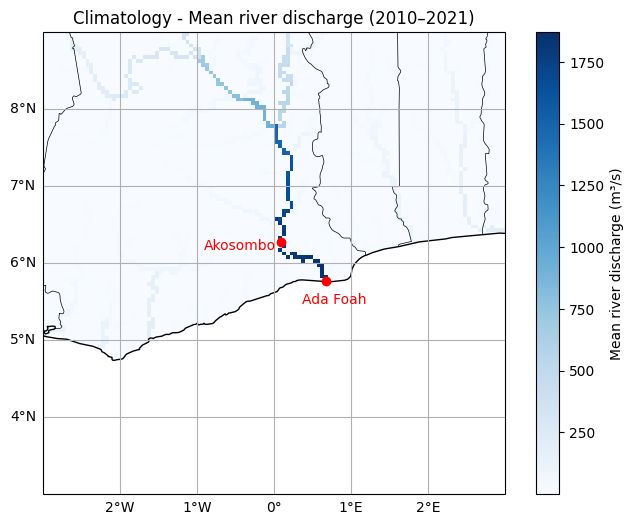

In [22]:
nodata = 9999.0  # GloFAS missing value

# mask nodata first
glofas_masked = glofas_sorted.where(glofas_sorted.dis24 != nodata)

# climatology
glofas_clim = glofas_masked['dis24'].mean('time')

# plot
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines('10m'); ax.add_feature(cfeature.BORDERS, linewidth=0.5)

glofas_clim.plot(
    ax=ax, x='longitude', y='latitude',
    transform=ccrs.PlateCarree(), cmap='Blues',
    cbar_kwargs={'label':'Mean river discharge (m³/s)'}
)

# points (be explicit about transform)
ax.plot(lon_estuary, lat_estuary, 'o', color='red', transform=ccrs.PlateCarree())
ax.text(lon_estuary-0.3, lat_estuary-0.3, 'Ada Foah',
        color='red', transform=ccrs.PlateCarree())
ax.plot(lon_lake, lat_lake, 'o', color='red', transform=ccrs.PlateCarree())
ax.text(lon_lake-1, lat_lake-0.1, 'Akosombo',
        color='red', transform=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
plt.title('Climatology - Mean river discharge (2010–2021)')
plt.show()


### Temporal variability of the 'raw' climatic index

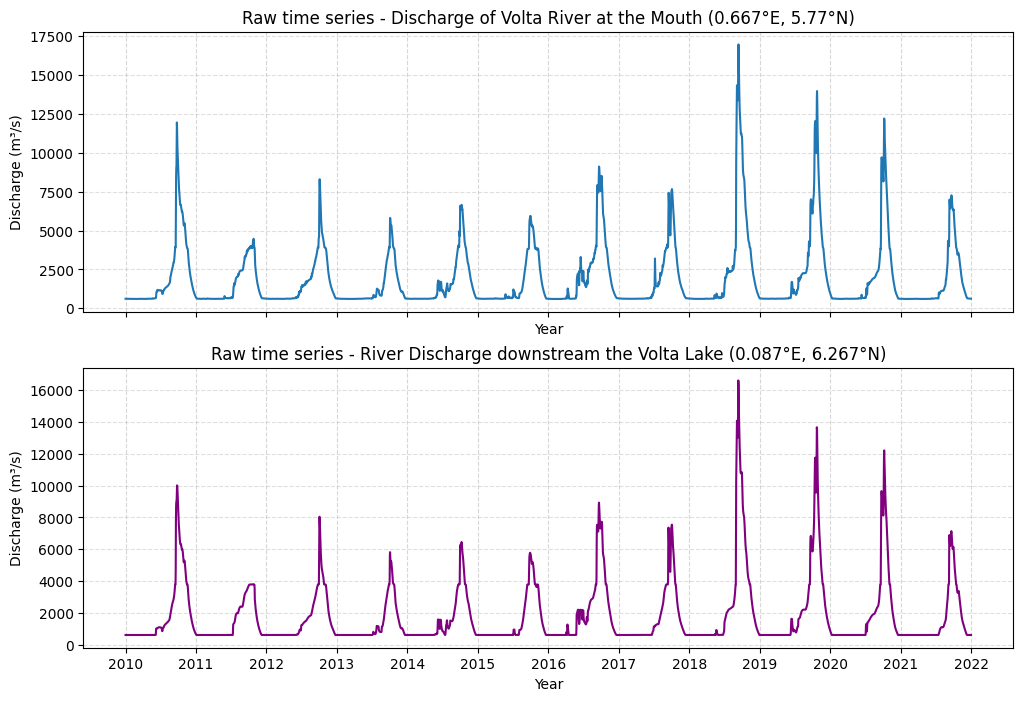

In [23]:
# Timeseries of River Discharge at the two reference points

# Plot
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)

# --- Estuary ---
ax1.plot(rd_estuary.time, rd_estuary, linestyle='-')
ax1.set_title("Raw time series - Discharge of Volta River at the Mouth (0.667°E, 5.77°N)")
ax1.set_ylabel("Discharge (m³/s)")  
ax1.set_xlabel("Year")
ax1.grid(True)
# vertical lines: one per month
ax1.grid(True, axis='x', which='major', alpha=0.5)
# a few horizontal lines (major only)
ax1.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)

# --- Volta Lake ---
ax2.plot(rd_lake.time, rd_lake, linestyle='-', color='purple')
ax2.set_title("Raw time series - River Discharge downstream the Volta Lake (0.087°E, 6.267°N)")
ax2.set_ylabel("Discharge (m³/s)")  
ax2.set_xlabel("Year")
# vertical lines: one per month
ax2.grid(True, axis='x', which='major', alpha=0.5)
# a few horizontal lines (major only)
ax2.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)

# one vertical grid line per year
year_loc = mdates.YearLocator()              # every year
year_fmt = mdates.DateFormatter('%Y')

for ax in (ax1, ax2):
    ax.xaxis.set_major_locator(year_loc)
    ax.xaxis.set_major_formatter(year_fmt)
    ax.grid(True, axis='x', which='major', linestyle='--', alpha=0.5)

plt.show()

### Climatology for RD

In [24]:
# -----------------------------
# Daily climatology and anomaly
# -----------------------------

# drop Feb 29 to get a 365-day climatology
is_feb29e = (rd_estuary.time.dt.month == 2) & (rd_estuary.time.dt.day == 29)
rdE_noleap = rd_estuary.sel(time=~is_feb29e)
rdE_noleap = rdE_noleap.convert_calendar("noleap", dim="time", align_on="date")


is_feb29l = (rd_lake.time.dt.month == 2) & (rd_lake.time.dt.day == 29)
rdL_noleap = rd_lake.sel(time=~is_feb29l)
rdL_noleap = rdL_noleap.convert_calendar("noleap", dim="time", align_on="date")

# --- Daily climatology (2010–2021) ---
rdE_dailyclim = rdE_noleap.groupby('time.dayofyear').mean('time')
rdL_dailyclim = rdL_noleap.groupby('time.dayofyear').mean('time')

dates_clim = pd.date_range("2010-01-01", periods=int(rdE_dailyclim.sizes["dayofyear"]), freq="D")
rdE_dailyclim = rdE_dailyclim.assign_coords(date=("dayofyear", dates_clim))
rdL_dailyclim = rdL_dailyclim.assign_coords(date=("dayofyear", dates_clim))

# --- Daily anomalies (value - daily climatology) ---
rdE_dailyanom = rdE_noleap.groupby('time.dayofyear') - rdE_dailyclim
rdE_dailyanom = rdE_dailyanom.assign_coords(date=("time", to_datetime64_from_cftime(rdE_dailyanom["time"])))

rdL_dailyanom = rdL_noleap.groupby('time.dayofyear') - rdL_dailyclim
rdL_dailyanom = rdL_dailyanom.assign_coords(date=("time", to_datetime64_from_cftime(rdL_dailyanom["time"])))

# ---

In [25]:
# -------------------------------
# Monthly climatology and anomaly
# -------------------------------

# Monthly mean values at the two locations (E = estuary, L = lake)
rdE_mon = rd_estuary.resample(time='MS').mean()   # 'MS' = Month Start
rdL_mon = rd_lake.resample(time='MS').mean()

# Monthly climatology (average over all years for each month)
rdE_clim = rdE_mon.groupby('time.month').mean('time')   # dims: month
rdL_clim = rdL_mon.groupby('time.month').mean('time')

# Anomalies = monthly mean - climatology
rdE_anom = rdE_mon.groupby('time.month') - rdE_clim      # dims: time
rdL_anom = rdL_mon.groupby('time.month') - rdL_clim

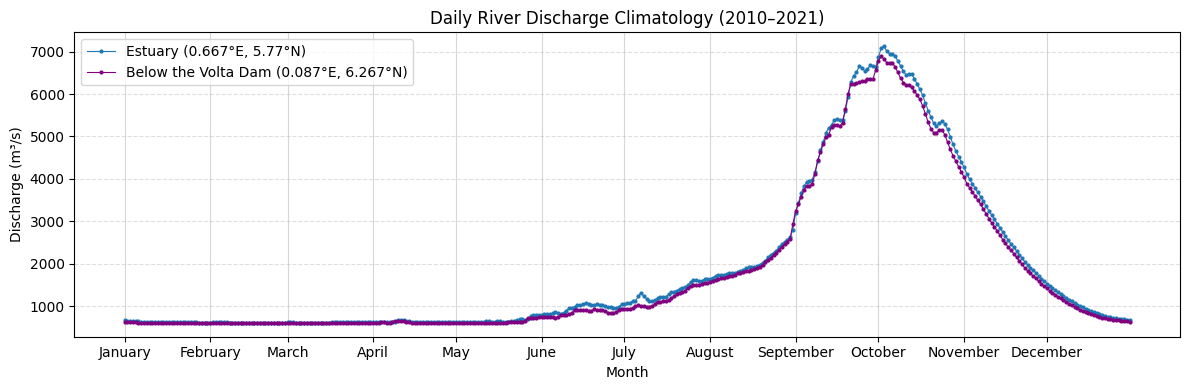

In [26]:
# --------------------------------------
# Daily RD climatology plot 
# --------------------------------------
month_names = [m[:3] for m in calendar.month_name[1:]]

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(rdE_dailyclim['date'].values, rdE_dailyclim.values, marker='o', 
        ms=2, lw=0.8, label = 'Estuary (0.667°E, 5.77°N)')
ax.plot(rdL_dailyclim['date'].values, rdL_dailyclim.values, marker = 'o',
        color = 'purple', ms=2, lw=0.8, label ='Below the Volta Dam (0.087°E, 6.267°N)')
ax.set_title("Daily River Discharge Climatology (2010–2021)")
ax.set_ylabel("Discharge (m³/s)")
ax.set_xlabel("Month")
ax.grid(True, axis='x', alpha=0.5)
ax.grid(True, axis='y', linestyle='--', alpha=0.4)
ax.legend()

# Tidy monthly ticks
ref_year = int(pd.to_datetime(rdE_dailyclim['date'].values[0]).year)  # or simply 2010
mticks, mlabels = month_ticks_for(ref_year)
ax.set_xticks(mticks)
ax.set_xticklabels(mlabels)
plt.tight_layout()
plt.show()

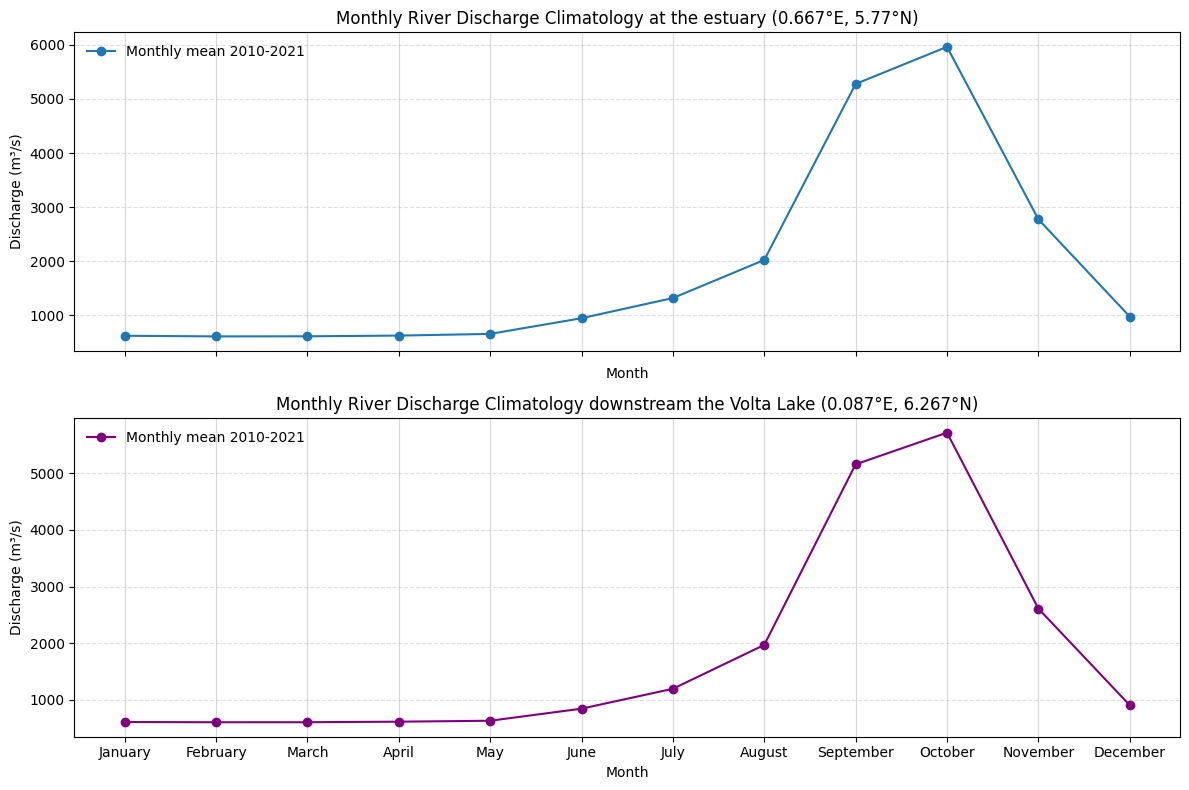

In [27]:
# --------------------------------------
# Monthly RD climatology plot 
# --------------------------------------
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)
months = list(calendar.month_name)[1:]

# --- Estuary ---
ax1.plot(rdE_clim['month'].values, rdE_clim.values, marker='o', label = 'Monthly mean 2010-2021')
ax1.set_title("Monthly River Discharge Climatology at the estuary (0.667°E, 5.77°N)")
ax1.set_ylabel("Discharge (m³/s)")
ax1.set_xlabel("Month", labelpad=8)
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(months)
# vertical lines: one per month
ax1.grid(True, axis='x', which='major', alpha=0.5)
# a few horizontal lines (major only)
ax1.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax1.legend(loc='upper left', frameon=False)


# --- Volta Lake ---
ax2.plot(rdL_clim['month'].values, rdL_clim.values, color='purple', marker='o', label = 'Monthly mean 2010-2021')
ax2.set_title("Monthly River Discharge Climatology downstream the Volta Lake (0.087°E, 6.267°N)")
ax2.set_ylabel("Discharge (m³/s)")
ax2.set_xlabel("Month")
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(months)
# vertical lines: one per month
ax2.grid(True, axis='x', which='major', alpha=0.5)
# a few horizontal lines (major only)
ax2.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax2.legend(loc='upper left', frameon=False)

plt.tight_layout()
plt.show()


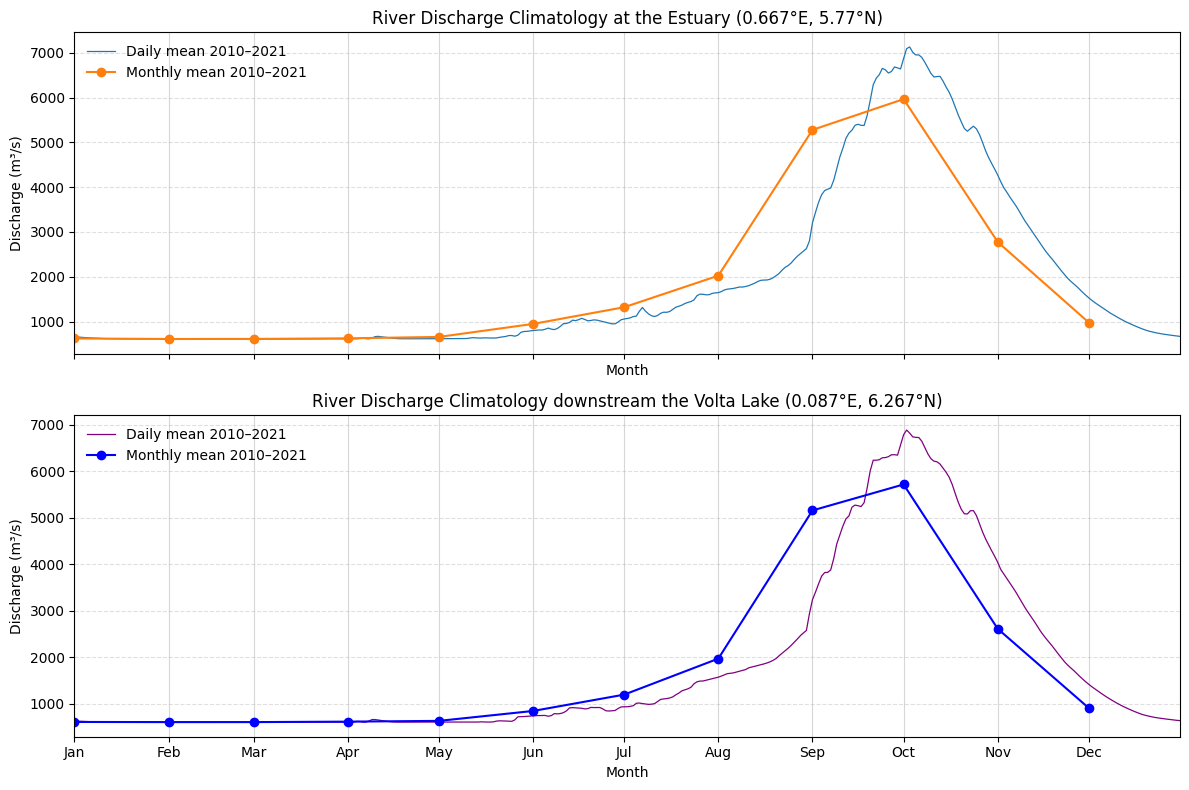

In [28]:

# -----------------------------------------------
# Daily vs Monthly RD climatology 
# -----------------------------------------------

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)
# reference year (already non-leap)
year = pd.to_datetime(rdE_dailyclim['date'].values[0]).year
# dates for the monthly (start the month in the same year as daily)
month_dates = pd.date_range(f"{year}-01-01", periods=12, freq="MS")

# --- Estuary ---
ax1.plot(rdE_dailyclim['date'].values, rdE_dailyclim.values, lw=0.9, label="Daily mean 2010–2021")
ax1.plot(month_dates, rdE_clim.values, marker='o', label="Monthly mean 2010–2021")

ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax1.set_xlim(pd.Timestamp(f"{year}-01-01"), pd.Timestamp(f"{year}-12-31"))

ax1.set_title("River Discharge Climatology at the Estuary (0.667°E, 5.77°N)")
ax1.set_ylabel("Discharge (m³/s)")
ax1.set_xlabel("Month")
ax1.grid(True, axis='x', alpha=0.5)
ax1.grid(True, axis='y', linestyle='--', alpha=0.4)
ax1.legend(frameon=False)

# --- Volta Lake ---
ax2.plot(rdL_dailyclim['date'].values, rdL_dailyclim.values, color = 'purple' , lw=0.9, label="Daily mean 2010–2021")
ax2.plot(month_dates, rdL_clim.values, marker='o', color= 'blue',  label="Monthly mean 2010–2021")

ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax2.set_xlim(pd.Timestamp(f"{year}-01-01"), pd.Timestamp(f"{year}-12-31"))

ax2.set_title("River Discharge Climatology downstream the Volta Lake (0.087°E, 6.267°N)")
ax2.set_ylabel("Discharge (m³/s)")
ax2.set_xlabel("Month")
ax2.grid(True, axis='x', alpha=0.5)
ax2.grid(True, axis='y', linestyle='--', alpha=0.4)
ax2.legend(frameon=False)
plt.tight_layout()
plt.show()


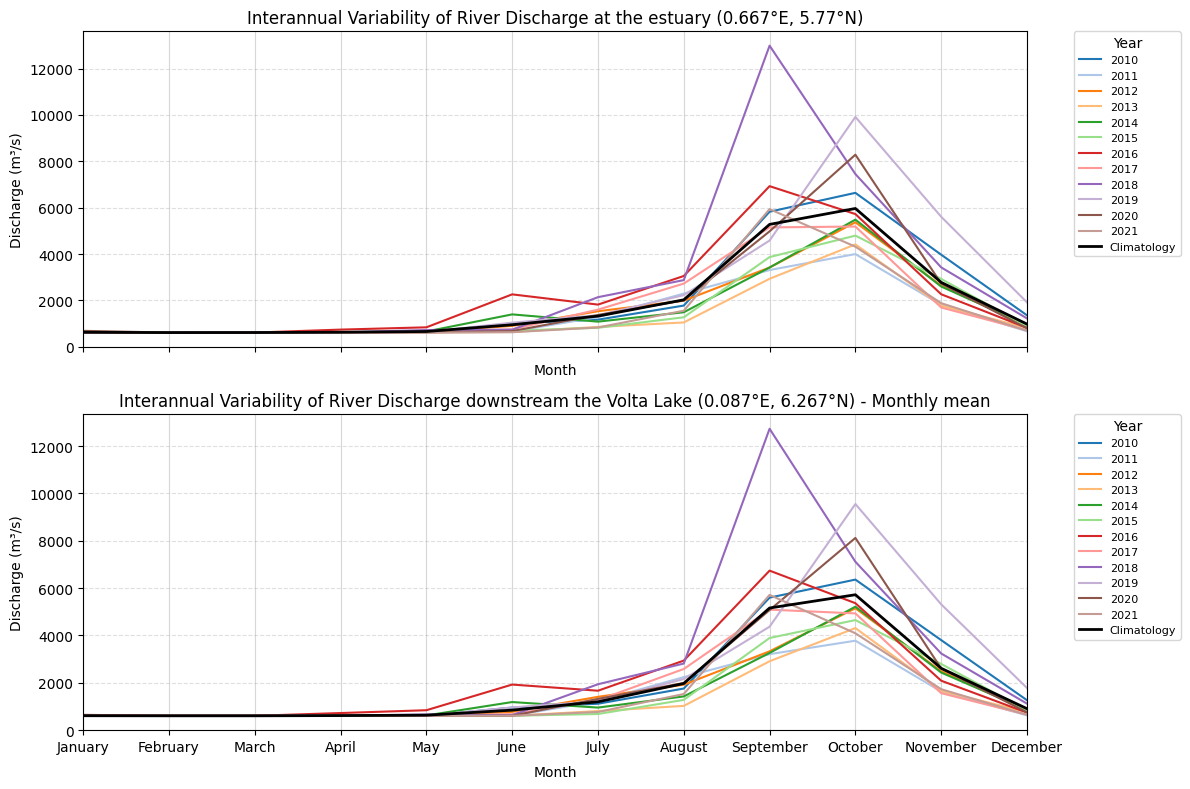

In [29]:
# --------------------------------------
# Monthly mean river discharge
# --------------------------------------
years = sorted(set(rd_estuary['time'].dt.year.values))

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)
cmap = plt.get_cmap('tab20')
colors = [cmap(i % cmap.N) for i in range(len(years))]

# --- Estuary ---
for i, (y1, yy1) in enumerate(rdE_mon.groupby('time.year')):
    # yy is the monthly series for that year (up to 12 points)
    ax1.plot(yy1['time.month'].values, yy1.values, label=str(y1), color=colors[i])

ax1.plot(rdE_clim['month'], rdE_clim.values, color='black', label='Climatology', linewidth=2)

ax1.set_title("Interannual Variability of River Discharge at the estuary (0.667°E, 5.77°N)")
ax1.set_ylabel("Discharge (m³/s)")
ax1.set_xlabel("Month", labelpad=8)
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(months)
ax1.set_xlim(1, 12)
ax1.set_axisbelow(True)
ax1.grid(True, axis='x', which='major', alpha=0.5)             
ax1.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=8, ncol=1, title="Year")

# --- Volta Lake ---
for j, (y2, yy2) in enumerate(rdL_mon.groupby('time.year')):
    # yy is the monthly series for that year (up to 12 points)
    ax2.plot(yy2['time.month'].values, yy2.values, label=str(y2), color=colors[j])

ax2.plot(rdL_clim['month'], rdL_clim.values, color='black', label='Climatology', linewidth=2)

ax2.set_title("Interannual Variability of River Discharge downstream the Volta Lake (0.087°E, 6.267°N) - Monthly mean")
ax2.set_ylabel("Discharge (m³/s)")
ax2.set_xlabel("Month", labelpad=8)
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(months)
ax2.set_xlim(1, 12)
ax2.set_axisbelow(True)
ax2.grid(True, axis='x', which='major', alpha=0.5)
ax2.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=8, ncol=1, title="Year")

plt.tight_layout()
plt.show()

### Anomaly of RD
#### Anomalies without detrending

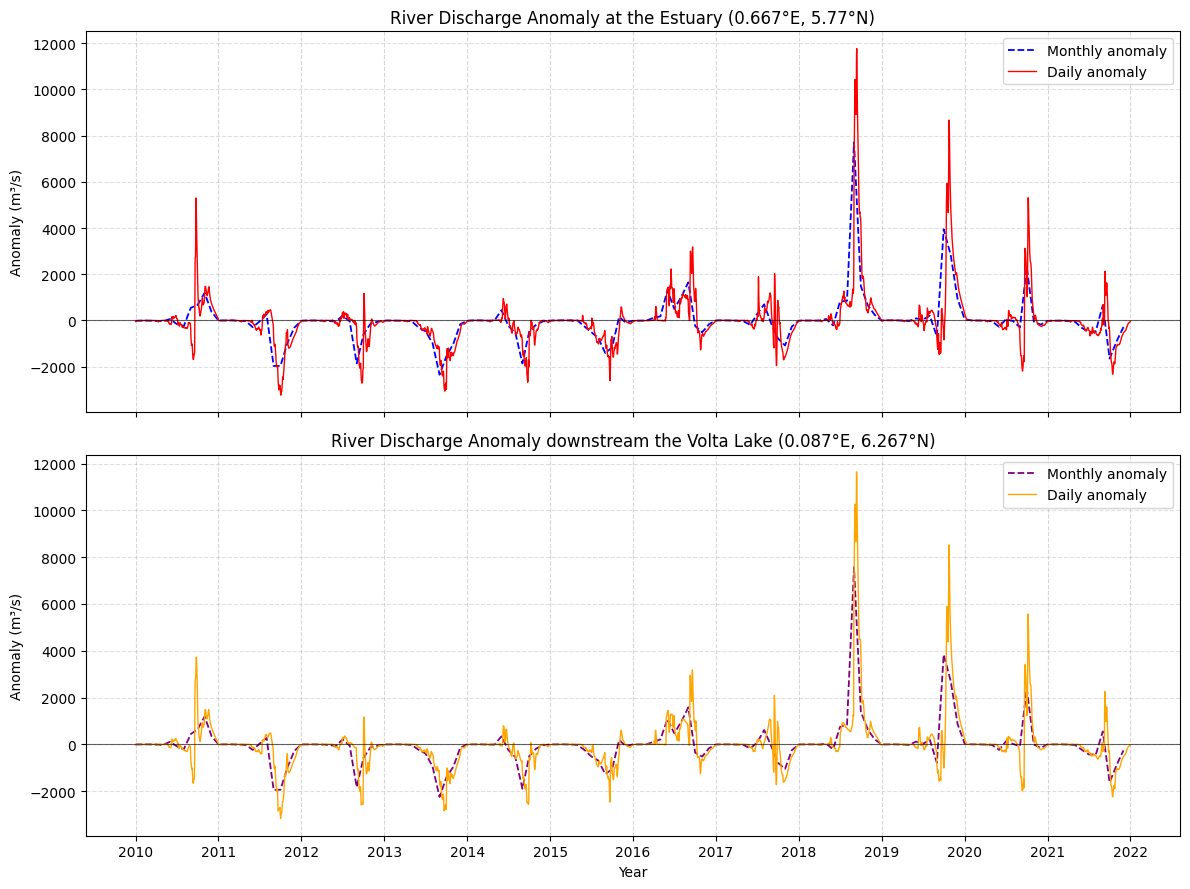

In [30]:
# Unique years + one extra for right edge
years = np.unique(rdE_dailyanom['time.year'].values)
years_ext = np.append(years, years[-1] + 1)
year_ticks = [np.datetime64(f"{y}-01-01") for y in years_ext]

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 9), sharex=True)

# --- Estuary ---
ax1.plot(rdE_anom['time'], rdE_anom.values, color='b', linewidth=1.3, linestyle = '--', label = 'Monthly anomaly')
ax1.plot(rdE_dailyanom['date'].values, rdE_dailyanom.values, linewidth=1, color= 'r', label = 'Daily anomaly')
ax1.axhline(0, color='k', linewidth=0.8, alpha=0.6)
ax1.set_title("River Discharge Anomaly at the Estuary (0.667°E, 5.77°N)")
ax1.set_ylabel("Anomaly (m³/s)")
ax1.set_xticks(year_ticks)
ax1.set_xticklabels(years_ext)
ax1.grid(True, axis='x', which='major', linestyle='--', alpha=0.5)
ax1.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax1.legend()

# --- Volta Lake ---
ax2.plot(rdL_anom['time'], rdL_anom.values, color='purple', linewidth=1.3, linestyle = '--', label = 'Monthly anomaly')
ax2.plot(rdL_dailyanom['date'].values, rdL_dailyanom.values, linewidth=1, color= 'orange', label = 'Daily anomaly')
ax2.axhline(0, color='k', linewidth=0.8, alpha=0.6)
ax2.set_title("River Discharge Anomaly downstream the Volta Lake (0.087°E, 6.267°N)")
ax2.set_ylabel("Anomaly (m³/s)")
ax2.set_xlabel("Year")
ax2.set_xticks(year_ticks)
ax2.set_xticklabels(years_ext)
ax2.grid(True, axis='x', which='major', linestyle='--', alpha=0.5)
ax2.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax2.legend()

plt.tight_layout()
plt.show()

In [31]:
# Checking on the highest values at Akosombo
val = rdL_dailyclim.where(rdL_dailyclim['date'] == np.datetime64('2010-09-13'), drop=True).squeeze()
val1d = rd_lake.where(rd_lake['time'] == np.datetime64('2018-09-13'), drop=True).squeeze()
val2d = rdL_dailyanom.where(rdL_dailyanom['date'] == np.datetime64('2018-09-13'), drop=True).squeeze()

print('Daily max climatology at Akosombo:', val.values)
print('Daily river discharge max at Akosombo:', val1d.values)
print('Daily max anomaly at Akosombo:', val2d.values)




Daily max climatology at Akosombo: 5039.7935
Daily river discharge max at Akosombo: 16393.531
Daily max anomaly at Akosombo: 11353.738


In [32]:
# Checking on the highest daily and monthly values at the estuary
val = rdE_dailyclim.where(rdE_dailyclim['date'] == np.datetime64('2010-10-03'), drop=True).squeeze()
val1 = rd_estuary.where(rd_estuary['time'] == np.datetime64('2011-10-03'),  drop=True).squeeze()
val2 = rdE_dailyanom.where(rdE_dailyanom['date'] == np.datetime64('2011-10-03'), drop=True).squeeze()

print('Daily climatology at the estuary:', val.values)
print('Daily river discharge at the estuary:', val1.values)
print('Daily anomaly at the estuary:', val2.values)
print('')
valm = rdE_clim.where(rdE_clim['month'] == 9,drop=True).squeeze()
val1m = rdE_mon.where(rdE_mon['time'] == np.datetime64('2018-09-01'), drop=True).squeeze()
val2m = rdE_anom.where(rdE_anom['time'] == np.datetime64('2018-09-01'), drop=True).squeeze()

print('Monthly max climatology at the estuary:', valm.values)
print('Monthly river discharge max at the estuary:', val1m.values)
print('Monthly max anomaly at the estuary:', val2m.values)
print('')

# Checking on the highest daily anomaly value
print('Daily anomaly maximum at the estuary', rdE_dailyanom.max())
print('Happened on the', rdE_dailyanom.idxmax())

# Checking on the lowest daily anomaly value
print('Daily anomaly minimum at the estuary', rdE_dailyanom.min())
print('Happened on the', rdE_dailyanom.idxmin())



Daily climatology at the estuary: 7129.2466
Daily river discharge at the estuary: 3898.3594
Daily anomaly at the estuary: -3230.8872

Monthly max climatology at the estuary: 5277.8867
Monthly river discharge max at the estuary: 12990.454
Monthly max anomaly at the estuary: 7712.5674

Daily anomaly maximum at the estuary <xarray.DataArray 'dis24' ()> Size: 4B
array(11768.285, dtype=float32)
Happened on the <xarray.DataArray 'time' ()> Size: 8B
array(cftime.DatetimeNoLeap(2018, 9, 13, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)
Daily anomaly minimum at the estuary <xarray.DataArray 'dis24' ()> Size: 4B
array(-3230.8872, dtype=float32)
Happened on the <xarray.DataArray 'time' ()> Size: 8B
array(cftime.DatetimeNoLeap(2011, 10, 3, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)


#### Detrended anomaly
To better understand the variability of a certain climatic index, it is convenient to remove the seasonal cycle from the timeseries by computing the anomaly as the difference between the monthly mean and the long-term monthly mean (the climatology) for each month. In this way we obtain a timesereis of anomaly values that oscillate around the zero (between ...), and that better represent the variability of river discharge in the Keta basin, in Ghana, within the period 2010-2021.

In [33]:
# --------------------------------------
# Detrended climatologies and anomalies
# --------------------------------------
baseline = ('2010-01-01','2021-12-31')

# ---------- ESTUARY ----------
# trend and detrended time series
rdE_danom_from_anomd, rdE_clim_from_anomd, rdE_trend = anomd(rd_estuary, baseline=baseline, deg=1)
rdE_detr = rd_estuary - rdE_trend.interp(time=rd_estuary['time'])

# detrended monthly climatology
rdE_dclim_m = rdE_detr.sel(time=slice(*baseline)).groupby('time.month').mean('time')

# detrended daily climatology
is_feb29_E = (rdE_detr.time.dt.month == 2) & (rdE_detr.time.dt.day == 29)
rdE_detr_noleap = rdE_detr.sel(time=~is_feb29_E).convert_calendar("noleap", dim="time", align_on="date")
rdE_dclim_d = rdE_detr_noleap.sel(time=slice(*baseline)).groupby('time.dayofyear').mean('time')

dates_clim = pd.date_range("2010-01-01", periods=int(rdE_dclim_d.sizes["dayofyear"]), freq="D")
rdE_dclim_d = rdE_dclim_d.assign_coords(date=("dayofyear", dates_clim))

# detrended anomalies
rdE_danom_d = rdE_detr_noleap.groupby('time.dayofyear') - rdE_dclim_d
rdE_danom_d = rdE_danom_d.assign_coords(date=("time", to_datetime64_from_cftime(rdE_danom_d["time"])))

rdE_danom_m = rdE_detr.resample(time='MS').mean().groupby('time.month') - rdE_dclim_m

# ---------- VOLTA LAKE ----------
# trend and detrended time series
rdL_danom_from_anomd, rdL_clim_from_anomd, rdL_trend = anomd(rd_lake, baseline=baseline, deg=1)
rdL_detr = rd_lake - rdL_trend.interp(time=rd_lake['time'])

# detrended monthly climatology
rdL_dclim_m = rdL_detr.sel(time=slice(*baseline)).groupby('time.month').mean('time')

# detrended daily climatology
is_feb29_L = (rdL_detr.time.dt.month == 2) & (rdL_detr.time.dt.day == 29)
rdL_detr_noleap = rdL_detr.sel(time=~is_feb29_L).convert_calendar("noleap", dim="time", align_on="date")
rdL_dclim_d = rdL_detr_noleap.sel(time=slice(*baseline)).groupby('time.dayofyear').mean('time')

dates_clim = pd.date_range("2010-01-01", periods=int(rdL_dclim_d.sizes["dayofyear"]), freq="D")
rdL_dclim_d = rdL_dclim_d.assign_coords(date=("dayofyear", dates_clim))

# detrended anomalies
rdL_danom_d = rdL_detr_noleap.groupby('time.dayofyear') - rdL_dclim_d
rdL_danom_d = rdL_danom_d.assign_coords(date=("time", to_datetime64_from_cftime(rdL_danom_d["time"])))

rdL_danom_m = rdL_detr.resample(time='MS').mean().groupby('time.month') - rdL_dclim_m


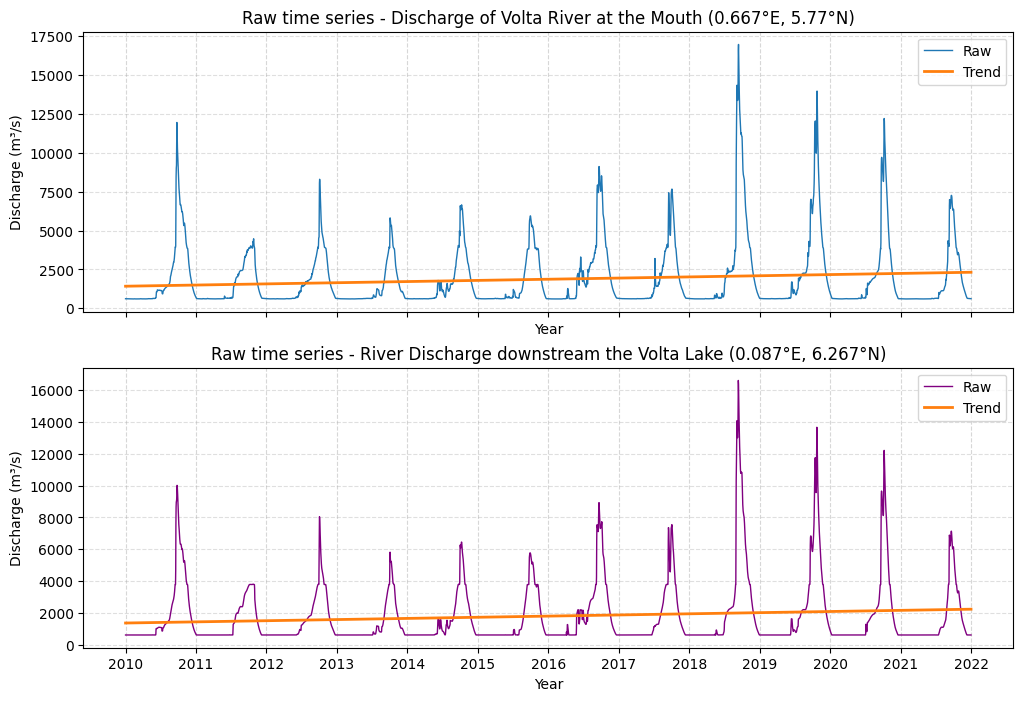

In [34]:
#-----------------------------------------------------------------------
# Timeseries of River Discharge at the two reference points with trend
#-----------------------------------------------------------------------

# Plot
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)

# --- Estuary ---
ax1.plot(rd_estuary.time, rd_estuary, linestyle='-', lw = 1, label = 'Raw')
ax1.plot(rdE_trend['time'], rdE_trend, linewidth=2, label="Trend", color="tab:orange")
ax1.set_title("Raw time series - Discharge of Volta River at the Mouth (0.667°E, 5.77°N)")
ax1.set_ylabel("Discharge (m³/s)")  
ax1.set_xlabel("Year")
ax1.grid(True)
# vertical lines: one per month
ax1.grid(True, axis='x', which='major', alpha=0.5)
# a few horizontal lines (major only)
ax1.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax1.legend()

# --- Volta Lake ---
ax2.plot(rd_lake.time, rd_lake, linestyle='-', lw = 1, color='purple', label = 'Raw')
ax2.plot(rdL_trend['time'], rdL_trend, linewidth=2, label="Trend", color="tab:orange")
ax2.set_title("Raw time series - River Discharge downstream the Volta Lake (0.087°E, 6.267°N)")
ax2.set_ylabel("Discharge (m³/s)")  
ax2.set_xlabel("Year")
# vertical lines: one per month
ax2.grid(True, axis='x', which='major', alpha=0.5)
# a few horizontal lines (major only)
ax2.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax2.legend()

import matplotlib.dates as mdates

# one vertical grid line per year
year_loc = mdates.YearLocator()              # every year
year_fmt = mdates.DateFormatter('%Y')

for ax in (ax1, ax2):
    ax.xaxis.set_major_locator(year_loc)
    ax.xaxis.set_major_formatter(year_fmt)
    ax.grid(True, axis='x', which='major', linestyle='--', alpha=0.5)

plt.show()

In [35]:
# Investigate trend characteristics
def trend_stats(trend_da, raw_da, baseline):
    tr = trend_da.sel(time=slice(*baseline))
    t = tr['time'].dt.year + (tr['time'].dt.dayofyear - 1)/365.25
    m, c = np.polyfit(t, tr.values, 1)  # m ≈ m³/s per year
    mean_base = float(raw_da.sel(time=slice(*baseline)).mean())
    return {
        "slope_m3s_per_year": float(m),
        "slope_m3s_per_decade": float(m*10),
        "delta_over_baseline_m3s": float(tr.values[-1]-tr.values[0]),
        "percent_per_decade": float(100*(m*10)/mean_base),
        "baseline_mean_m3s": mean_base,
    }

E = trend_stats(rdE_trend, rd_estuary, baseline)
L = trend_stats(rdL_trend, rd_lake, baseline)
print("Estuary:", E)
print("Lake:", L)


Estuary: {'slope_m3s_per_year': 74.80414250735267, 'slope_m3s_per_decade': 748.0414250735266, 'delta_over_baseline_m3s': 897.4322509765625, 'percent_per_decade': 39.982029840084614, 'baseline_mean_m3s': 1870.944091796875}
Lake: {'slope_m3s_per_year': 72.46451901881483, 'slope_m3s_per_decade': 724.6451901881483, 'delta_over_baseline_m3s': 869.363525390625, 'percent_per_decade': 40.46825095416305, 'baseline_mean_m3s': 1790.651123046875}


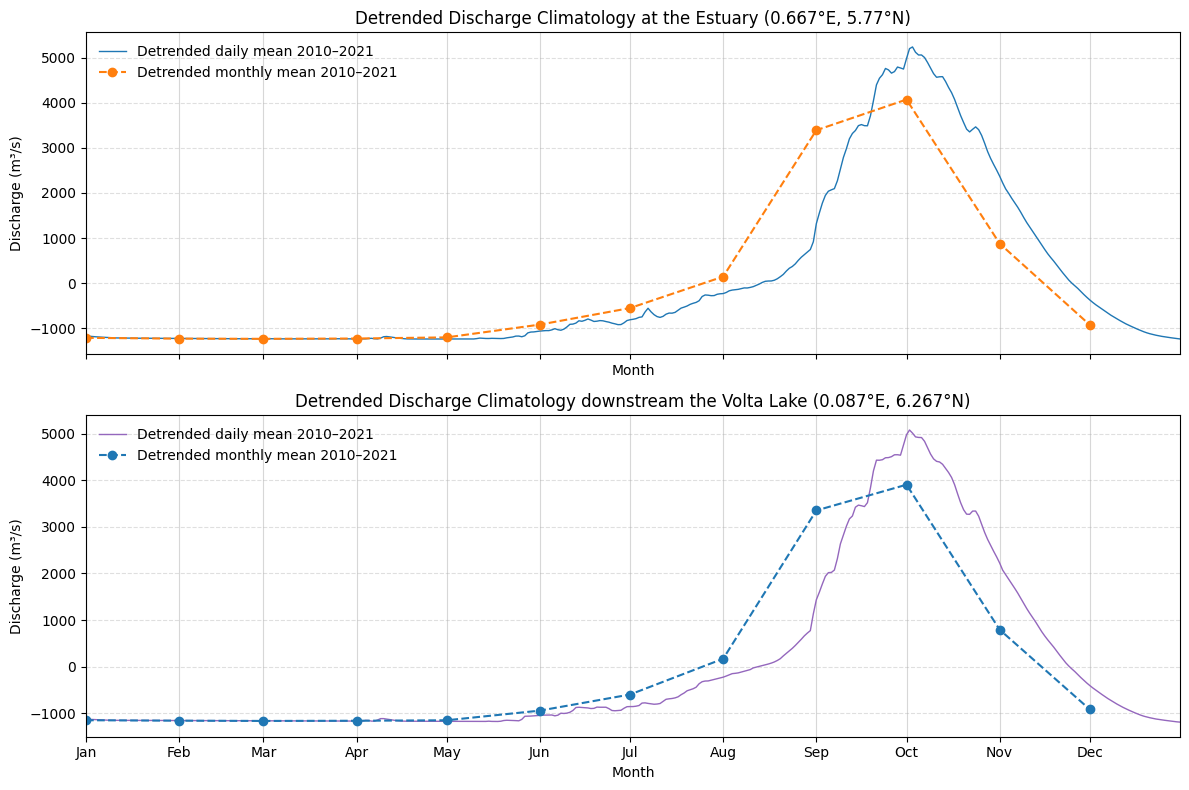

In [36]:
# -----------------------------------------------
# Daily vs Monthly detrended climatology plot
# -----------------------------------------------

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)

# reference year (already non-leap)
year = pd.to_datetime(rdE_dclim_d['date'].values[0]).year
month_dates = pd.date_range(f"{year}-01-01", periods=12, freq="MS")

# --- Estuary (detrended) ---
ax1.plot(rdE_dclim_d['date'].values, rdE_dclim_d.values, lw=1, label="Detrended daily mean 2010–2021")
ax1.plot(month_dates, rdE_dclim_m.values, marker='o', linestyle='--', label="Detrended monthly mean 2010–2021")

ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax1.set_xlim(pd.Timestamp(f"{year}-01-01"), pd.Timestamp(f"{year}-12-31"))
ax1.set_title("Detrended Discharge Climatology at the Estuary (0.667°E, 5.77°N)")
ax1.set_ylabel("Discharge (m³/s)")
ax1.set_xlabel("Month")
ax1.grid(True, axis='x', alpha=0.5)
ax1.grid(True, axis='y', linestyle='--', alpha=0.4)
ax1.legend(frameon=False)

# --- Volta Lake (detrended) ---
ax2.plot(rdL_dclim_d['date'].values, rdL_dclim_d.values, color='tab:purple', lw=1, label="Detrended daily mean 2010–2021")
ax2.plot(month_dates, rdL_dclim_m.values, marker='o', linestyle='--', color='tab:blue', label="Detrended monthly mean 2010–2021")

ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax2.set_xlim(pd.Timestamp(f"{year}-01-01"), pd.Timestamp(f"{year}-12-31"))
ax2.set_title("Detrended Discharge Climatology downstream the Volta Lake (0.087°E, 6.267°N)")
ax2.set_ylabel("Discharge (m³/s)")
ax2.set_xlabel("Month")
ax2.grid(True, axis='x', alpha=0.5)
ax2.grid(True, axis='y', linestyle='--', alpha=0.4)
ax2.legend(frameon=False)

plt.tight_layout()
plt.show()


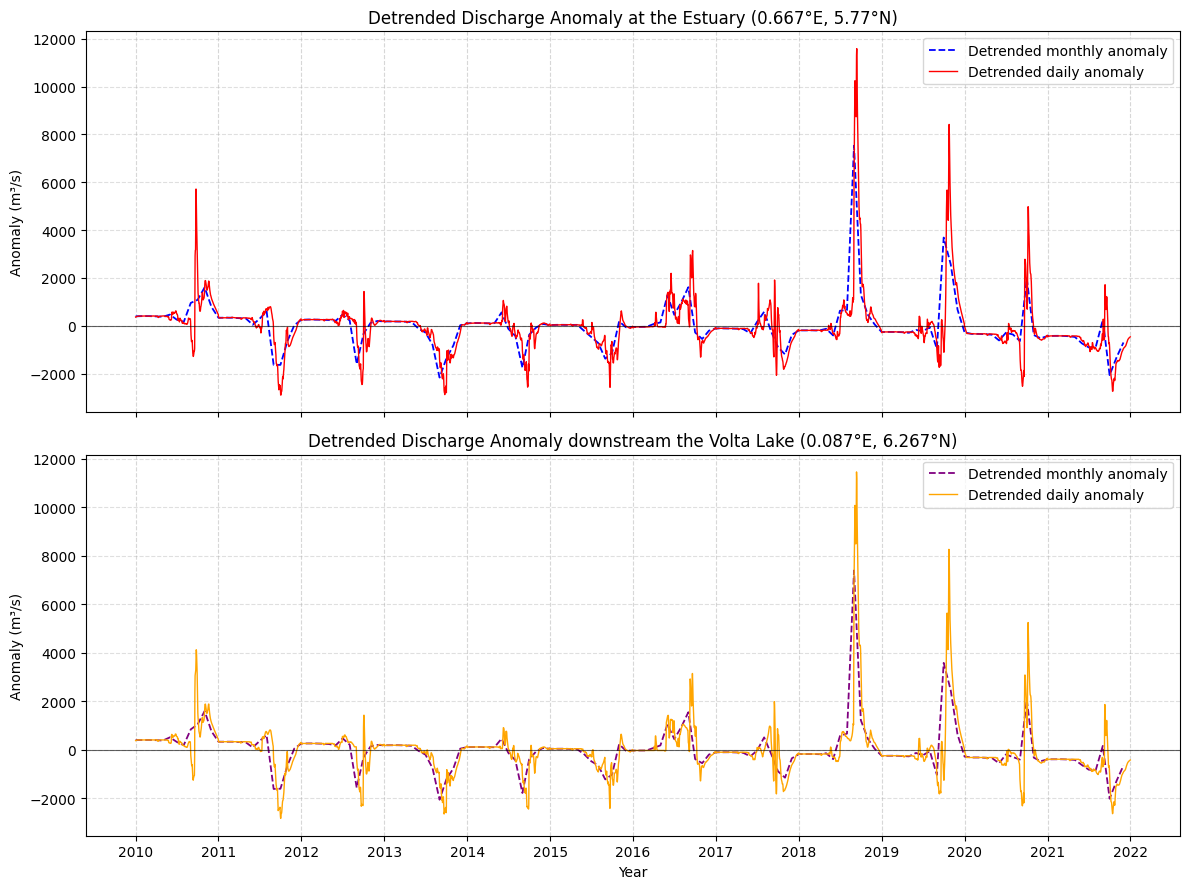

In [37]:
# --------------------------------------
# Daily vs Monthly detrended anomalies 
# --------------------------------------
# Unique years + one extra for right edge
years = np.unique(rdE_danom_d['time.year'].values)
years_ext = np.append(years, years[-1] + 1)
year_ticks = [np.datetime64(f"{y}-01-01") for y in years_ext]

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 9), sharex=True)

# --- Estuary ---
ax1.plot(rdE_danom_m['time'], rdE_danom_m.values, color='b', linewidth=1.3, linestyle = '--', label = 'Detrended monthly anomaly')
ax1.plot(rdE_danom_d['date'].values, rdE_danom_d.values, linewidth=1, color= 'r', label = 'Detrended daily anomaly')
ax1.axhline(0, color='k', linewidth=0.8, alpha=0.6)
ax1.set_title("Detrended Discharge Anomaly at the Estuary (0.667°E, 5.77°N)")
ax1.set_ylabel("Anomaly (m³/s)")
ax1.set_xticks(year_ticks)
ax1.set_xticklabels(years_ext)
ax1.grid(True, axis='x', which='major', linestyle='--', alpha=0.5)
ax1.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax1.legend()

# --- Volta Lake ---
ax2.plot(rdL_danom_m['time'], rdL_danom_m.values, color='purple', linewidth=1.3, linestyle = '--', label = 'Detrended monthly anomaly')
ax2.plot(rdL_danom_d['date'].values, rdL_danom_d.values, linewidth=1, color= 'orange', label = 'Detrended daily anomaly')
ax2.axhline(0, color='k', linewidth=0.8, alpha=0.6)
ax2.set_title("Detrended Discharge Anomaly downstream the Volta Lake (0.087°E, 6.267°N)")
ax2.set_ylabel("Anomaly (m³/s)")
ax2.set_xlabel("Year")
ax2.set_xticks(year_ticks)
ax2.set_xticklabels(years_ext)
ax2.grid(True, axis='x', which='major', linestyle='--', alpha=0.5)
ax2.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax2.legend()

plt.tight_layout()
plt.show()


## Water level - JRC data
### Temporal variability of the 'raw' climatic index

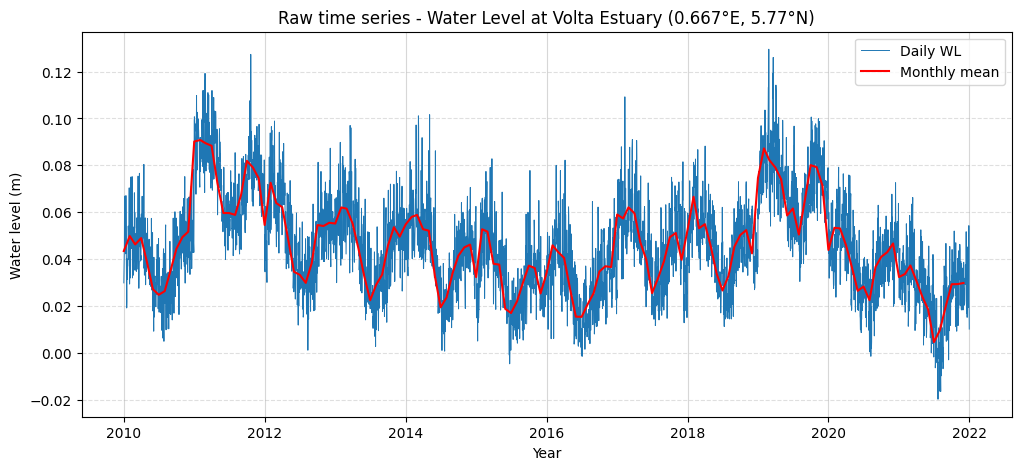

In [38]:
# Timeseries of Water Level

# Plot
fig, ax1 = plt.subplots(figsize=(12, 5), sharex=True)
ax1.plot(wl_estuary.time, wl_estuary, linestyle='-', lw=0.7, label = 'Daily WL')
# Monthly mean values at the two locations (E = estuary, L = lake)
wl_mon = wl_estuary.resample(time='MS').mean()   # 'MS' = Month Start

ax1.plot(wl_mon.time, wl_mon, linestyle = '-', color = 'r', label = 'Monthly mean')
ax1.set_title("Raw time series - Water Level at Volta Estuary (0.667°E, 5.77°N)")
ax1.set_ylabel("Water level (m)")  
ax1.set_xlabel("Year")
ax1.grid(True)
ax1.legend()
# vertical lines: one per month
ax1.grid(True, axis='x', which='major', alpha=0.5)
# a few horizontal lines (major only)
ax1.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)

#plt.tight_layout()
plt.show()

### Climatology for WL

In [39]:
# -----------------------------
# Daily climatology and anomaly
# -----------------------------

# drop Feb 29 to get a 365-day climatology
is_feb29w = (wl_estuary.time.dt.month == 2) & (wl_estuary.time.dt.day == 29)
wl_noleap = wl_estuary.sel(time=~is_feb29w)
wl_noleap = wl_noleap.convert_calendar("noleap", dim="time", align_on="date")

# --- Daily climatology (2010–2021) ---
wl_dailyclim = wl_noleap.groupby('time.dayofyear').mean('time')

dates_climw = pd.date_range("2010-01-01", periods=int(wl_dailyclim.sizes["dayofyear"]), freq="D")
wl_dailyclim = wl_dailyclim.assign_coords(date=("dayofyear", dates_climw))

wl_dailyanom = wl_noleap.groupby('time.dayofyear') - wl_dailyclim
wl_dailyanom = wl_dailyanom.assign_coords(date=("time", to_datetime64_from_cftime(wl_dailyanom["time"])))

# -------------------------------
# Monthly climatology and anomaly
# -------------------------------

# Monthly mean values at the two locations (E = estuary, L = lake)
wl_mon = wl_estuary.resample(time='MS').mean()   # 'MS' = Month Start

# Monthly climatology (average over all years for each month)
wl_clim = wl_mon.groupby('time.month').mean('time')   # dims: month

# Anomalies = monthly mean - climatology
wl_anom = wl_mon.groupby('time.month') - wl_clim       # dims: time

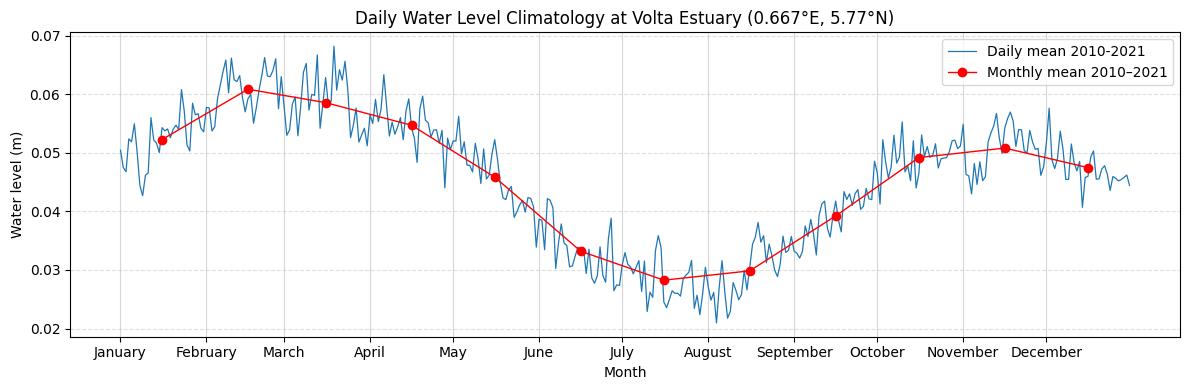

In [40]:
# Plots
months = list(calendar.month_name)[1:]
# reference year (already non-leap)
year = pd.to_datetime(wl_dailyclim['date'].values[0]).year
# dates for the monthly (start the month in the same year as daily)
month_dates = pd.date_range(f"{year}-01-01", periods=12, freq="MS")
month_dates_mid = month_dates + pd.Timedelta(days=15)

# --------------------------------------
# Daily and monthly climatology plot WL
# --------------------------------------
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(wl_dailyclim['date'].values, wl_dailyclim.values,  
        ms=2, lw=0.9, label = 'Daily mean 2010-2021')
ax.plot(month_dates_mid, wl_clim.values, marker='o', lw=1, color ='r',
        label='Monthly mean 2010–2021')
ax.set_title("Daily Water Level Climatology at Volta Estuary (0.667°E, 5.77°N)")
ax.set_ylabel("Water level (m)")
ax.set_xlabel("Month")
ax.grid(True, axis='x', alpha=0.5)
ax.grid(True, axis='y', linestyle='--', alpha=0.4)
ax.legend()

month = pd.date_range('2010-01-01', '2011-01-01', freq='MS')[:-1]
ax.set_xticks(month)
ax.set_xticklabels(months)
ax.legend(loc='upper right', frameon=True)

plt.tight_layout()
plt.show()

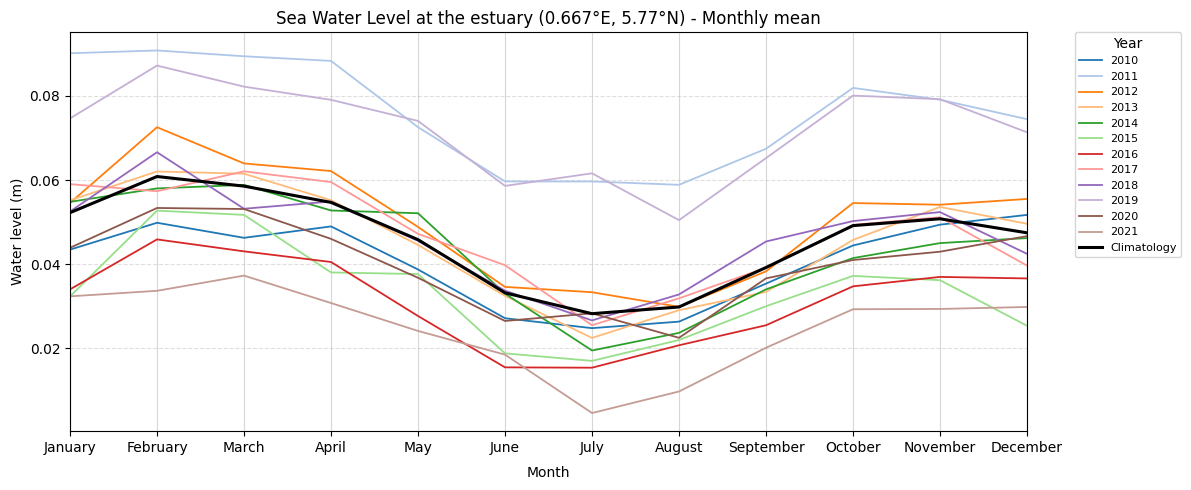

In [41]:
years = sorted(set(rd_estuary['time'].dt.year.values))

# --------------------------------------
# Monthly mean water level
# --------------------------------------

fig, ax1 = plt.subplots(figsize=(12, 5), sharex=True)
cmap = plt.get_cmap('tab20')
colors = [cmap(i % cmap.N) for i in range(len(years))]

for i, (y1, yy1) in enumerate(wl_mon.groupby('time.year')):
    # yy is the monthly series for that year (up to 12 points)
    ax1.plot(yy1['time.month'].values, yy1.values, label=str(y1), lw=1.3, color=colors[i])

ax1.plot(wl_clim['month'], wl_clim.values, color='black', label='Climatology', linewidth=2.2)
ax1.set_title("Sea Water Level at the estuary (0.667°E, 5.77°N) - Monthly mean")
ax1.set_ylabel("Water level (m)")
ax1.set_xlabel("Month", labelpad=8)
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(months)
ax1.set_xlim(1, 12)
ax1.set_axisbelow(True)
ax1.grid(True, axis='x', which='major', alpha=0.5)             
ax1.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=8, ncol=1, title="Year")

plt.tight_layout()
plt.show()

### WL anomaly
#### Anomalies without detrending

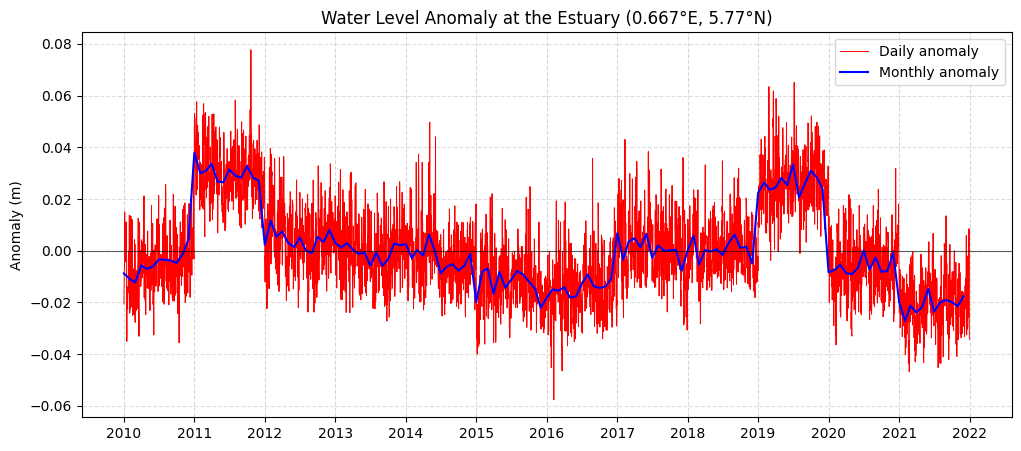

In [42]:
# get unique years from anomalies
years = np.unique(wl_anom['time.year'].values)

# add one extra year so the grid reaches the end of the plot
years_ext = np.append(years, years[-1] + 1)
year_ticks = [np.datetime64(f"{y}-01-01") for y in years_ext]

# --------------------------------------
# Monthly and daily water level anomaly
# --------------------------------------

fig, ax1 = plt.subplots(figsize=(12, 5), sharex=True)

# --- Estuary ---
ax1.plot(wl_dailyanom['date'].values, wl_dailyanom.values, linewidth=0.7, color= 'r', label = 'Daily anomaly')
ax1.plot(wl_anom['time'], wl_anom.values, color='blue', linewidth=1.5, label = 'Monthly anomaly')
ax1.axhline(0, color='k', linewidth=0.8, alpha=0.6)  # baseline
ax1.set_title("Water Level Anomaly at the Estuary (0.667°E, 5.77°N)")
ax1.set_ylabel("Anomaly (m)")
ax1.set_xticks(year_ticks)
ax1.set_xticklabels(years_ext)  # show all year numbers including the last
ax1.grid(True, axis='x', which='major', linestyle='--', alpha=0.5)
ax1.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax1.legend()

plt.show()


#### Detrended anomaly
To better understand the variability of a certain climatic index, it is convenient to remove the seasonal cycle from the timeseries by computing the anomaly as the difference between the monthly mean and the long-term monthly mean (the climatology) for each month. In this way we obtain a timesereis of anomaly values that oscillate around the zero (between ...), and that better represent the variability of river discharge in the Keta basin, in Ghana, within the period 2010-2021.

In [43]:
# --------------------------------------
# Detrended climatologies and anomalies
# --------------------------------------
baseline = ('2010-01-01','2021-12-31')

# trend and detrended time series
wl_danom_from_anomd, wl_clim_from_anomd, wl_trend = anomd(wl_estuary, baseline=baseline, deg=1)
wl_detr = wl_estuary - wl_trend.interp(time=wl_estuary['time'])

# detrended monthly climatology
wl_dclim_m = wl_detr.sel(time=slice(*baseline)).groupby('time.month').mean('time')

# detrended daily climatology
is_feb29_w = (wl_detr.time.dt.month == 2) & (wl_detr.time.dt.day == 29)
wl_detr_noleap = wl_detr.sel(time=~is_feb29_w).convert_calendar("noleap", dim="time", align_on="date")
wl_dclim_d = wl_detr_noleap.sel(time=slice(*baseline)).groupby('time.dayofyear').mean('time')

dates_climw = pd.date_range("2010-01-01", periods=int(wl_dclim_d.sizes["dayofyear"]), freq="D")
wl_dclim_d = wl_dclim_d.assign_coords(date=("dayofyear", dates_climw))

# detrended anomalies
wl_danom_d = wl_detr_noleap.groupby('time.dayofyear') - wl_dclim_d
wl_danom_d = wl_danom_d.assign_coords(date=("time", to_datetime64_from_cftime(wl_danom_d["time"])))

wl_danom_m = wl_detr.resample(time='MS').mean().groupby('time.month') - wl_dclim_m

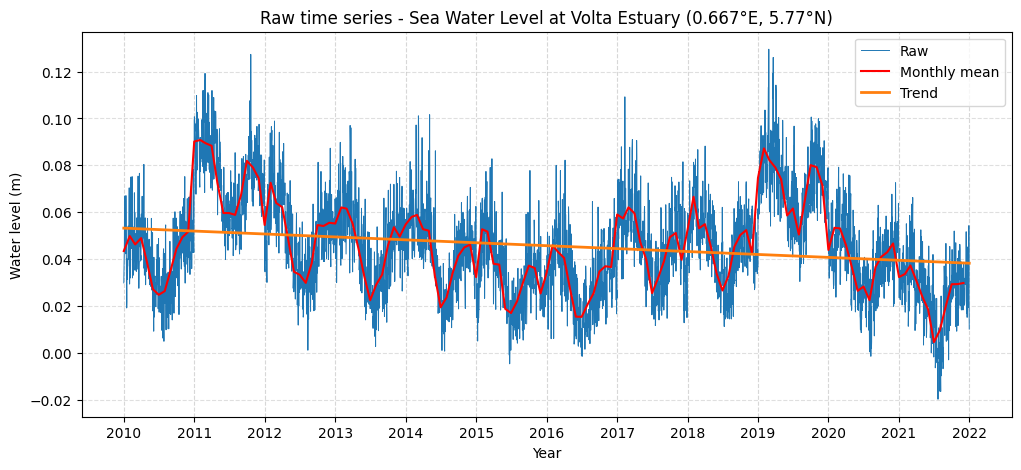

In [44]:
#--------------------------------------
# Timeseries of Water Level with trend
#--------------------------------------
# Plot
fig, ax = plt.subplots(figsize=(12, 5), sharex=True)
ax.plot(wl_estuary.time, wl_estuary, linestyle='-', lw = 0.7, label = 'Raw')
ax.plot(wl_mon.time, wl_mon, linestyle = '-', color = 'r', label = 'Monthly mean')
ax.plot(wl_trend['time'], wl_trend, linewidth=2, label="Trend", color="tab:orange")
ax.set_title("Raw time series - Sea Water Level at Volta Estuary (0.667°E, 5.77°N)")
ax.set_ylabel("Water level (m)")  
ax.set_xlabel("Year")
ax.grid(True)
# vertical lines: one per month
ax.grid(True, axis='x', which='major', alpha=0.5)
# a few horizontal lines (major only)
ax.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax.legend()

# one vertical grid line per year
year_loc = mdates.YearLocator()              # every year
year_fmt = mdates.DateFormatter('%Y')

ax.xaxis.set_major_locator(year_loc)
ax.xaxis.set_major_formatter(year_fmt)
ax.grid(True, axis='x', which='major', linestyle='--', alpha=0.5)

plt.show()

In [45]:
wl_danom_d

<xarray.DataArray (time: 4380)> Size: 35kB
array([-0.02740397, -0.01845397, -0.01422897, ...,  0.01535482,
       -0.01613684, -0.02739518], shape=(4380,))
Coordinates:
  * time       (time) object 35kB 2010-01-01 00:00:00 ... 2021-12-31 00:00:00
    dayofyear  (time) int64 35kB 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    date       (time) datetime64[ns] 35kB 2010-01-01 2010-01-02 ... 2021-12-31

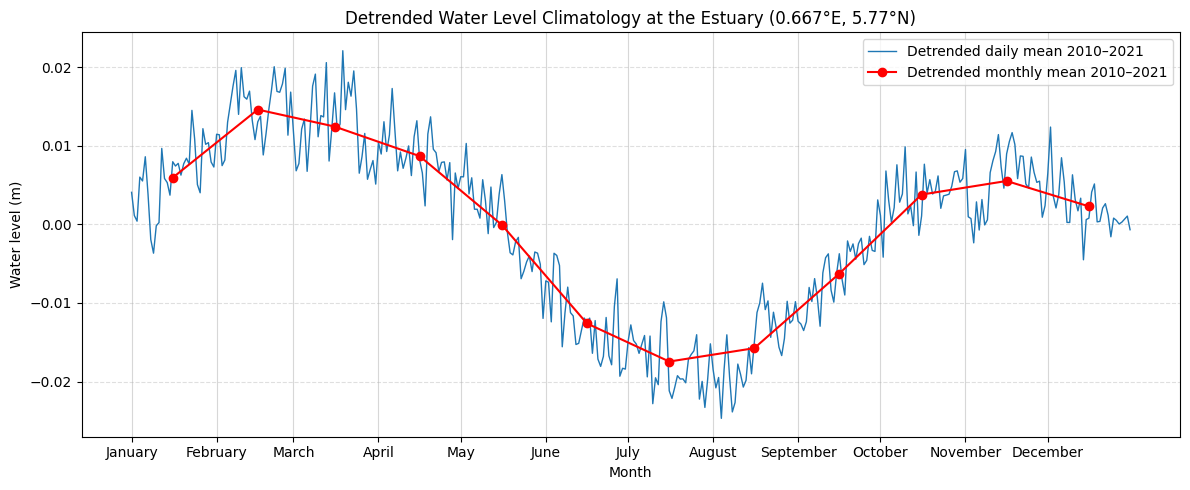

In [46]:
# -----------------------------------------------
# Daily vs Monthly detrended climatology plot
# -----------------------------------------------
fig, ax = plt.subplots(figsize=(12, 5), sharex=True)

# reference year (already non-leap)
year = pd.to_datetime(wl_dclim_d['date'].values[0]).year
# dates for the monthly (start the month in the same year as daily)
month_dates = pd.date_range(f"{year}-01-01", periods=12, freq="MS")
month_dates_mid = month_dates + pd.Timedelta(days=15)

ax.plot(wl_dclim_d['date'].values, wl_dclim_d.values, lw=1, label="Detrended daily mean 2010–2021")
ax.plot(month_dates_mid, wl_dclim_m.values, marker='o', color= 'r', label="Detrended monthly mean 2010–2021")
ax.set_title("Detrended Water Level Climatology at the Estuary (0.667°E, 5.77°N)")
ax.set_ylabel("Water level (m)")
ax.set_xlabel("Month")
month = pd.date_range('2010-01-01', '2011-01-01', freq='MS')[:-1]
ax.set_xticks(month)
ax.set_xticklabels(months)
ax.grid(True, axis='x', alpha=0.5)
ax.grid(True, axis='y', linestyle='--', alpha=0.4)
ax.legend(loc='upper right', frameon=True)

plt.tight_layout()
plt.show()


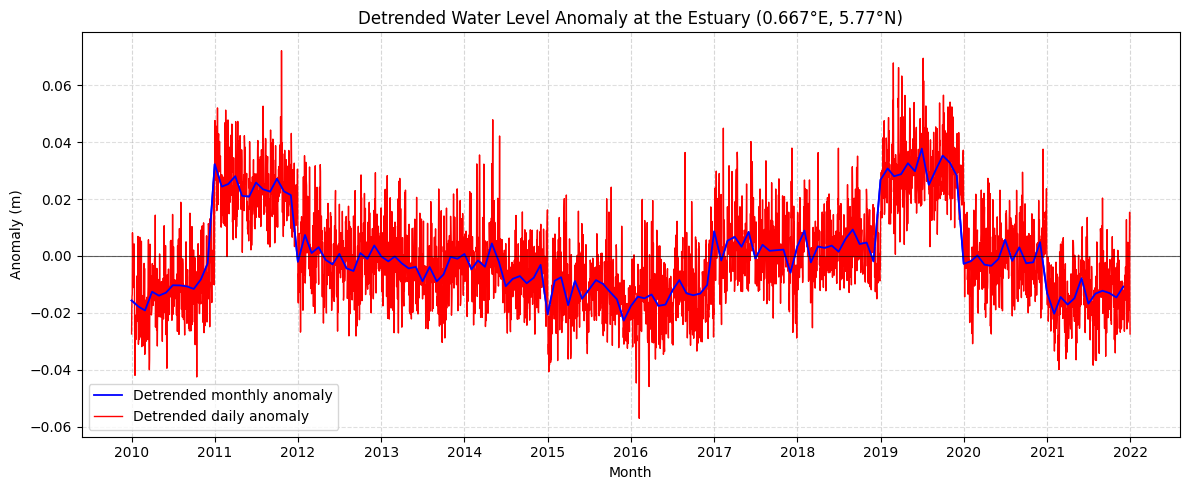

In [47]:
# ----------------------------------------
# Daily vs Monthly detrended anomaly plot 
# ----------------------------------------
# Unique years + one extra for right edge
years = np.unique(wl_danom_d['time.year'].values)
years_ext = np.append(years, years[-1] + 1)
year_ticks = [np.datetime64(f"{y}-01-01") for y in years_ext]

fig, ax = plt.subplots(figsize=(12, 5), sharex=True)

ax.plot(wl_danom_m['time'].values, wl_danom_m.values, lw=1.3, color = 'b', label="Detrended monthly anomaly")
ax.plot(wl_danom_d['time'].values, wl_danom_d.values, lw = 1, color = 'r', label="Detrended daily anomaly")
ax.plot(wl_danom_m['time'].values, wl_danom_m.values, lw=1.3, color = 'b')
ax.axhline(0, color='k', linewidth=0.8, alpha=0.6)
ax.set_title("Detrended Water Level Anomaly at the Estuary (0.667°E, 5.77°N)")
ax.set_ylabel("Anomaly (m)")
ax.set_xlabel("Month")
ax.set_xticks(year_ticks)
ax.set_xticklabels(years_ext)
ax.grid(True, axis='x', which='major', linestyle='--', alpha=0.5)
ax.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax.legend()

plt.tight_layout()
plt.show()


## Align series and detrended anomalies

In [48]:
# --- INPUTS ---
START = "2010-01-01"
END   = "2021-12-31"
SEASON_MONTHS = None            # e.g. [8,9,10,11] for Aug–Nov, or None for all-year
# --------------

def align_RD_WL(rd_estuary, wl_estuary, start=START, end=END, season_months=SEASON_MONTHS):
    """
    Align daily discharge (RD) and water level (WL) on the same dates.
    - Coerce to pandas Series with clean DatetimeIndex (normalized to midnight)
    - Clip each to [start,end] individually
    - Inner-join (keep overlapping dates only)
    - Optional seasonal filter
    Returns a DataFrame with columns ['RD','WL'].
    """
    # 1) to Series and ensure datetime, no tz
    rd = rd_estuary.to_series()  # pandas Series with DatetimeIndex
    wl = wl_estuary.to_series()

    # keep overlap and target period
    alignedQW = pd.concat({"RD": rd, "WL": wl}, axis=1).sort_index()
    alignedQW = alignedQW.loc[start:end].dropna()

    # enforce daily frequency (your data are daily; this just checks & warns)
    daily = pd.date_range(alignedQW.index.min(), alignedQW.index.max(), freq="D")
    if not alignedQW.index.equals(daily.intersection(alignedQW.index)):
        # don't reindex to avoid creating NaNs; just warn if irregular
        print("Note: index not strictly regular daily; proceeding with available days.")

    # optional seasonal filter
    if season_months is not None:
        alignedQW = alignedQW[alignedQW.index.month.isin(season_months)]

    # final sanity
    assert alignedQW.index.is_monotonic_increasing
    print(f"Aligned rows: {len(alignedQW)}  | years: {alignedQW.index.year.nunique()} | "
          f"period: {alignedQW.index.min().date()} → {alignedQW.index.max().date()}")
    if season_months:
        print(f"Filtered months: {season_months}")

    return alignedQW

alignedQW = align_RD_WL(rd_estuary, wl_estuary, START, END, SEASON_MONTHS)
alignedQW.head()


Aligned rows: 4383  | years: 12 | period: 2010-01-01 → 2021-12-31


,RD,WL
time,,
2010-01-01,616.109375,0.0299
2010-01-02,615.671875,0.0359
2010-01-03,615.140625,0.0394
2010-01-04,614.531250,0.0459
2010-01-05,613.953125,0.0669


In [49]:
def align_RD_WL_det_anom(rdE_danom_d, wl_danom_d,
                         start="2010-01-01", end="2021-12-31",
                         season_months=None):
    """
    Align daily discharge (RDda) and water level (WLda) detrended anomalies on the same dates.
    Returns a DataFrame with columns ['RDda','WLda'].
    """
    # to pandas Series
    rd_da = rdE_danom_d.to_series()
    wl_da = wl_danom_d.to_series()

    # ensure pandas DatetimeIndex (no cftime)
    if not isinstance(rd_da.index, pd.DatetimeIndex):
        rd_da.index = pd.to_datetime(rd_da.index.to_datetimeindex())
    if not isinstance(wl_da.index, pd.DatetimeIndex):
        wl_da.index = pd.to_datetime(wl_da.index.to_datetimeindex())

    # clip to period and inner-join
    df = pd.concat({"RDda": rd_da, "WLda": wl_da}, axis=1).sort_index()
    df = df.loc[start:end].dropna()

    # check daily regularity (warn only)
    daily = pd.date_range(df.index.min(), df.index.max(), freq="D")
    if not df.index.equals(daily.intersection(df.index)):
        print("Note: index not strictly regular daily; proceeding with available days.")

    # optional seasonal filter
    if season_months is not None:
        df = df[df.index.month.isin(season_months)]

    print(f"Aligned rows: {len(df)}  | years: {df.index.year.nunique()} | "
          f"period: {df.index.min().date()} → {df.index.max().date()}")
    if season_months:
        print(f"Filtered months: {season_months}")

    return df
alignedQW_da = align_RD_WL_det_anom(rdE_danom_d, wl_danom_d, START, END, SEASON_MONTHS)
alignedQW_da.head()


Aligned rows: 4380  | years: 12 | period: 2010-01-01 → 2021-12-31


C:\Users\aless\AppData\Local\Temp\ipykernel_40204\4021829564.py:14: FutureWarning: In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
  rd_da.index = pd.to_datetime(rd_da.index.to_datetimeindex())
C:\Users\aless\AppData\Local\Temp\ipykernel_40204\4021829564.py:14: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  rd_da.index = pd.to_datetime(rd_da.index.to_datetimeindex())
C:\Users\aless\AppData\Local\Temp\ipykernel_40204\4021829564.py:16: FutureWarning: In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex

,RDda,WLda
2010-01-01,366.388123,-0.027404
2010-01-02,372.095774,-0.018454
2010-01-03,377.451843,-0.014229
2010-01-04,382.295695,-0.013329
2010-01-05,386.188222,0.008163


# Extreme Analysis
## Univariate Extremes

### Block Maxima - Empirical return periods
Following the Block Maxima approach (Coles, 2001), the observation record is here divided into non-overlapping periods of equal length and restricts attention to the maximum observation in each block. The resulting series of annual maxima is then fitted with the GEV distribution, allowing the estimation for return levels, defined as quantiles corresponding to specidic return periods. In this way, observed extremes are associated with probabilities, and extrapolation beyond the observed record becomes possible. It should be said, however, that while GEV distribution provides the theoretical foundation for modeling block maxima, its derivation assumes underlying stationarity. Coles (2001, §6) emphasizes that environmental processes rarely satisfy this assumption due to seasonal cycles and long-term trends. Therefore, for non-stationary sequencies it's necessary either remove such structure (e.g. through detrended anomalies) or incorporate it explicitly in a non-stationary GEV model with time- or season-dependent parameters.

In practice, the data here are divided into annual blocks, from which only the **annual maximum** value is considered, creating a shorter series of 12 values for 2010-2021 (1). The **GEV distribution is then fitted to these annual maxima** (2), with shape, location and scale parameters estimated through maxima likelihood estimation (MLE). Then, the return periods are computed as the reciprocal of exceedance probability, T = 1/p. The corresponding return level (3) q = 1 - 1/T is the quantile of the fitted GEV distribution that is exceeded with probability 1/T in any given year (Coles, 2001, §3.2).

In the code, once the GEV parameters are estimated, each observed annual maximum is assigned to an empirical return period using the Weibull plotting position (4): Temp = (n+1)/m, where n is the number of annual maxima and m is the rank of the maximum (from the largest = 1, to the smallest = n). At the same time, the fitted GEV is used to compute the theoretical return level curve across a smooth grid of return periods up to a safe maximum (≈3× record length).

Lastly, the comparison of the empirical estimates from data (points) with the fitted model (curve) is here paralelly proposed for both the raw time series and the detrended anomalies.

In [51]:
import lmoments3 as lm
from lmoments3 import distr as lmd
import scipy.stats as st

print("OK:", lm.__version__)


OK: 1.0.8


C:\Users\aless\AppData\Local\Temp\ipykernel_40204\2254040555.py:3: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return series.resample("A-DEC").max().dropna()
C:\Users\aless\AppData\Local\Temp\ipykernel_40204\2254040555.py:3: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return series.resample("A-DEC").max().dropna()


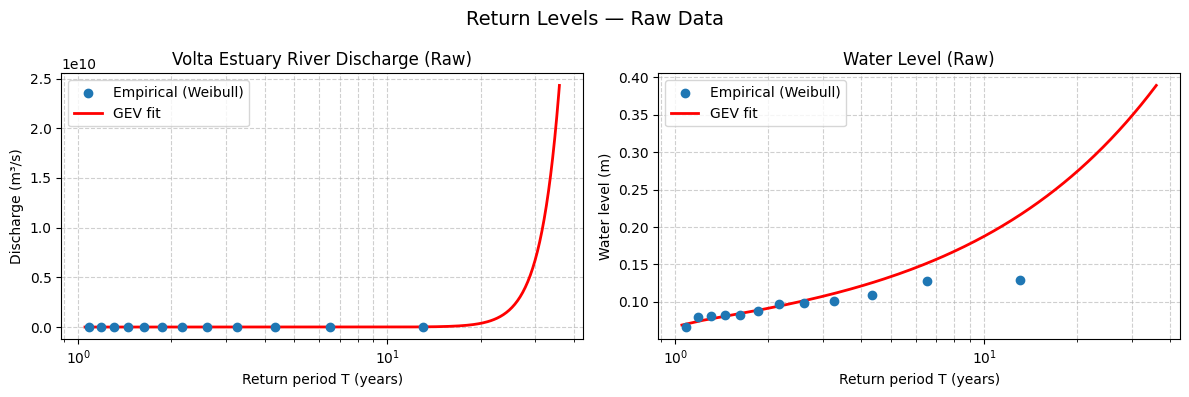

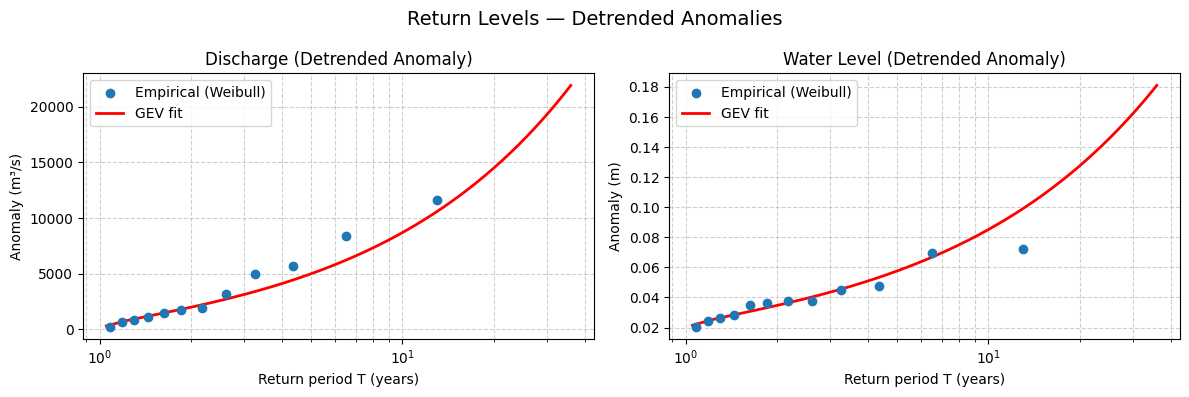

In [ ]:
# 1) Take annual maxima from the daily series
def annual_max(series):
    """Return annual maxima (one value per year)."""
    return series.resample("A-DEC").max().dropna()

# 2) Fit a GEV distribution to those maxima, parameters estimated by MLE
def fit_gev(am_series):
    """Fit GEV distribution to annual maxima."""
    shape, loc, scale = st.genextreme.fit(am_series.values)
    return shape, loc, scale

# 3) Compute return levels for a range of return periods T
def return_level_curve(shape, loc, scale, T):
    """Compute return levels for given return periods T."""
    q = 1 - 1/np.array(T)
    return st.genextreme.ppf(q, shape, loc=loc, scale=scale)

# 4) Plot empirical points (from Weibull plotting position) + fitted GEV curve.
def ax_return_levels(ax, am_series, title, ylabel, factor=3):
    """
    Plot a return level curve on a given matplotlib axis (ax).
    - factor: maximum multiple of record length for Tmax (to avoid extreme extrapolation)
    """
    n = len(am_series)           # number of annual maxima
    Tmax = n * factor            # maximum return period allowed
    shape, loc, scale = fit_gev(am_series)

    # Empirical return periods (Weibull plotting position)
    x = np.sort(am_series.values)[::-1]
    m = np.arange(1, n+1)
    T_emp = (n+1) / m

    # Theoretical GEV return level curve (limited to Tmax)
    T_theo = np.linspace(1.05, Tmax, 200)
    RL_theo = return_level_curve(shape, loc, scale, T_theo)

    # Plot empirical points and fitted GEV curve
    ax.scatter(T_emp, x, label="Empirical (Weibull)", zorder=3)
    ax.plot(T_theo, RL_theo, "r-", lw=2, label="GEV fit")

    # Axis formatting
    ax.set_xscale("log")
    ax.set_xlabel("Return period T (years)")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, which="both", ls="--", alpha=0.6)
    ax.legend()

# Compute annual maxima for each series
AM_RD   = annual_max(alignedQW["RD"])        # raw discharge
AM_WL   = annual_max(alignedQW["WL"])        # raw water level
AM_RDda = annual_max(alignedQW_da["RDda"])   # detrended anomaly discharge
AM_WLda = annual_max(alignedQW_da["WLda"])   # detrended anomaly water level

# Figure 1: Raw data (2 columns: discharge + water level)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax_return_levels(axes[0], AM_RD, "Volta Estuary River Discharge (Raw)", "Discharge (m³/s)")
ax_return_levels(axes[1], AM_WL, "Water Level (Raw)", "Water level (m)")
fig.suptitle("Return Levels — Raw Data", fontsize=14)
plt.tight_layout()
plt.show()

# Figure 2: Detrended anomalies (2 columns: discharge + water level)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax_return_levels(axes[0], AM_RDda, "Discharge (Detrended Anomaly)", "Anomaly (m³/s)")
ax_return_levels(axes[1], AM_WLda, "Water Level (Detrended Anomaly)", "Anomaly (m)")
fig.suptitle("Return Levels — Detrended Anomalies", fontsize=14)
plt.tight_layout()
plt.show()


Given the very short block maxima series, with only 12 years of data, the Maximum Likelihood Estimation method to estiamte the GEV parameters is very unstable. This is evident in the Volta Estuary River dicharge Return Levels for raw data: here the GEV curve explodes upwards very fast, wich is an unrealistic extrapolation.

Therefore, for short records such as this one, it is convinent to use Probability Weighted Moments (or L-moments), which is a much more robust method with short hydrological recors, and which produces more stable and realistic return levels.

C:\Users\aless\AppData\Local\Temp\ipykernel_40204\3055017.py:7: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return series.resample("A-DEC").max().dropna()


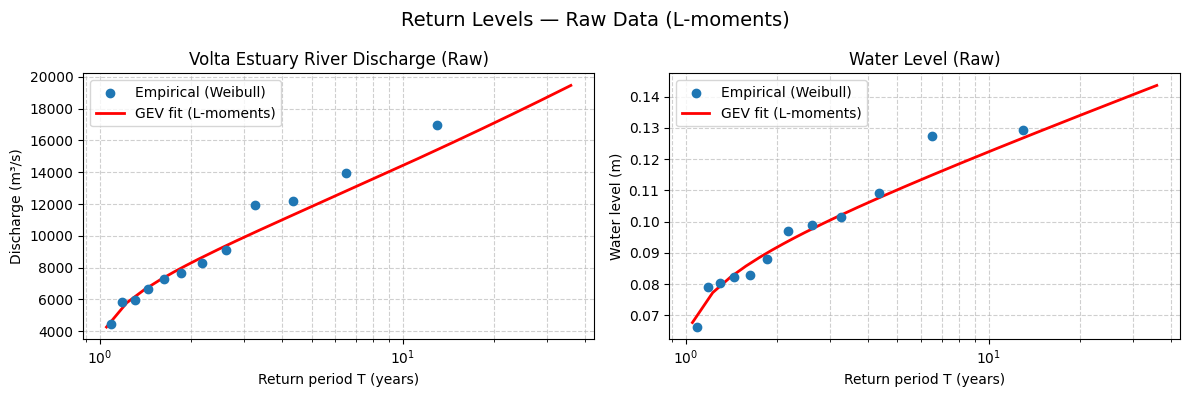

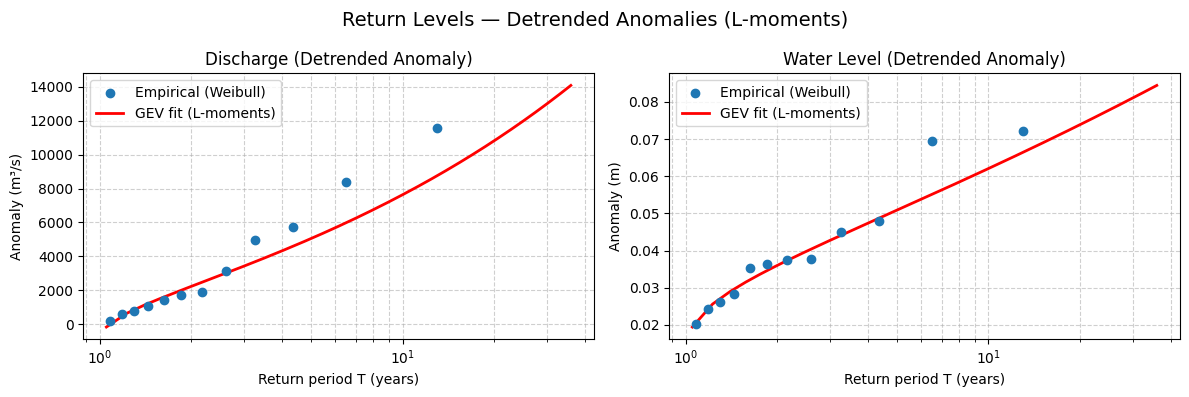

In [ ]:
# Fit with L-moments (PWM) instead of MLE (much more stable on short samples) 
from lmoments3 import distr as lmd

# 1) Take annual maxima from the daily series
def annual_max(series):
    """Return annual maxima (one value per year)."""
    return series.resample("A-DEC").max().dropna()

# 2) Fit a GEV distribution to those maxima, parameters estimated by L-moments
def fit_gev_lmom(am_series):
    """Fit GEV distribution to annual maxima using L-moments (PWM)."""
    return lmd.gev.lmom_fit(am_series.values)

# 3) Compute return levels for a range of return periods T
def return_level_curve_lmom(params, T):
    """Compute return levels for given return periods T from L-moments fit."""
    q = 1 - 1/np.array(T, float)
    c, loc, scale = params["c"], params["loc"], params["scale"]
    return lmd.gev.ppf(q, c, loc=loc, scale=scale)

# 4) Plot empirical points (from Weibull plotting position) + fitted GEV curve.
def ax_return_levels(ax, am_series, title, ylabel, factor=3):
    """
    Plot a return level curve on a given matplotlib axis (ax) using L-moments.
    - factor: maximum multiple of record length for Tmax (to avoid extreme extrapolation)
    """
    n = len(am_series)
    Tmax = n * factor
    params = fit_gev_lmom(am_series)

    # Empirical return periods (Weibull plotting position)
    x = np.sort(am_series.values)[::-1]
    m = np.arange(1, n+1)
    T_emp = (n+1) / m

    # Theoretical GEV return level curve (limited to Tmax)
    T_theo = np.linspace(1.05, Tmax, 200)
    RL_theo = return_level_curve_lmom(params, T_theo)

    # Plot
    ax.scatter(T_emp, x, label="Empirical (Weibull)", zorder=3)
    ax.plot(T_theo, RL_theo, "r-", lw=2, label="GEV fit (L-moments)")

    ax.set_xscale("log")
    ax.set_xlabel("Return period T (years)")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, which="both", ls="--", alpha=0.6)
    ax.legend()

# --- Example usage ---

AM_RD   = annual_max(alignedQW["RD"])      
AM_WL   = annual_max(alignedQW["WL"])      
AM_RDda = annual_max(alignedQW_da["RDda"]) 
AM_WLda = annual_max(alignedQW_da["WLda"]) 

# Figure 1: Raw
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax_return_levels(axes[0], AM_RD, "Volta Estuary River Discharge (Raw)", "Discharge (m³/s)")
ax_return_levels(axes[1], AM_WL, "Water Level (Raw)", "Water level (m)")
fig.suptitle("Return Levels — Raw Data (L-moments)", fontsize=14)
plt.tight_layout()
plt.show()

# Figure 2: Anomalies
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax_return_levels(axes[0], AM_RDda, "Discharge (Detrended Anomaly)", "Anomaly (m³/s)")
ax_return_levels(axes[1], AM_WLda, "Water Level (Detrended Anomaly)", "Anomaly (m)")
fig.suptitle("Return Levels — Detrended Anomalies (L-moments)", fontsize=14)
plt.tight_layout()
plt.show()


In [54]:
import numpy as np
import pandas as pd
import scipy.stats as st

# ---------- helpers ----------
def fit_gev_mle(x):
    """Return (shape, loc, scale) fitted by MLE (SciPy uses shape = -xi)."""
    return st.genextreme.fit(np.asarray(x))

def rl_from_params(params, T):
    """Return levels for return periods T given (shape, loc, scale)."""
    shape, loc, scale = params
    q = 1 - 1/np.asarray(T, dtype=float)      # non-exceedance prob
    return st.genextreme.ppf(q, shape, loc=loc, scale=scale)

def compute_return_levels(am_series, T=(2,5,10,20,30), n_boot=0, seed=0):
    """
    Compute return levels for chosen T. Optionally add bootstrap 95% CIs.
    - am_series: pandas Series of annual maxima
    - T: iterable of return periods (years)
    - n_boot: number of bootstrap resamples (0 = no CIs)
    """
    T = list(T)
    # Fit on the original data
    params_hat = fit_gev_mle(am_series.values)
    rl_hat = rl_from_params(params_hat, T)

    df = pd.DataFrame({"T (years)": T, "Return level": rl_hat})

    if n_boot and n_boot > 0:
        rng = np.random.default_rng(seed)
        boots = np.empty((n_boot, len(T)))
        x = am_series.values
        n = len(x)
        for b in range(n_boot):
            xb = x[rng.integers(0, n, size=n)]  # resample annual maxima
            try:
                pb = fit_gev_mle(xb)
                boots[b, :] = rl_from_params(pb, T)
            except Exception:
                boots[b, :] = np.nan

        df["RL p2.5"]  = np.nanpercentile(boots,  2.5, axis=0)
        df["RL p97.5"] = np.nanpercentile(boots, 97.5, axis=0)
    return df

# ---------- choose sensible T for a 12-year record ----------
RETURN_PERIODS = [2, 5, 10, 20, 30]   # stay ≤ ~3× record length

# ---------- build tables ----------
tbl_RD_raw   = compute_return_levels(AM_RD,   RETURN_PERIODS, n_boot=500, seed=42)
tbl_WL_raw   = compute_return_levels(AM_WL,   RETURN_PERIODS, n_boot=500, seed=42)
tbl_RD_anom  = compute_return_levels(AM_RDda, RETURN_PERIODS, n_boot=500, seed=42)
tbl_WL_anom  = compute_return_levels(AM_WLda, RETURN_PERIODS, n_boot=500, seed=42)

print("\n=== Discharge (Raw) ===\n",   tbl_RD_raw.round(3))
print("\n=== Water Level (Raw) ===\n", tbl_WL_raw.round(3))
print("\n=== Discharge (Detrended Anomaly) ===\n",  tbl_RD_anom.round(3))
print("\n=== Water Level (Detrended Anomaly) ===\n", tbl_WL_anom.round(3))


=== Discharge (Raw) ===
    T (years)  Return level   RL p2.5      RL p97.5
0          2  4.477008e+03  4472.389  1.174315e+04
1          5  1.720644e+04  4472.788  1.522515e+05
2         10  2.416855e+06  4473.698  2.349369e+07
3         20  3.690322e+08  4476.401  3.799384e+09
4         30  6.665200e+09  4480.023  7.390836e+10

=== Water Level (Raw) ===
    T (years)  Return level  RL p2.5  RL p97.5
0          2         0.091    0.078     0.116
1          5         0.134    0.093     0.141
2         10         0.188    0.101     0.202
3         20         0.275    0.107     0.305
4         30         0.349    0.108     0.394

=== Discharge (Detrended Anomaly) ===
    T (years)  Return level  RL p2.5      RL p97.5
0          2      1974.040  191.548  2.769763e+03
1          5      4995.483  192.680  2.166709e+05
2         10      8693.486  197.164  5.476578e+07
3         20     14478.108  216.424  3.250686e+10
4         30     19302.614  249.802  1.227627e+12

=== Water Level (Detren

From the both raw and detrended fits are unstable because 12 maxima is just too few. For discharge, you should switch to POT (Peaks over Threshold) which uses more data per year.


Water Level: both raw and detrended data give reasonable GEV fits, with the detrended anomaly being slightly “tighter.” These results you can report with more confidence.

### Peaks-Over-Threshold
An alternative to the block maxima approach is the Peaks-Over-Threshold (POT) method, which avoids discharding potentially useful information by considering all observations that exceed a sufficiently high threshold. Instead of retaining only the single maximum value within each block (e.g., one per year), the POT approach models the **distribution of threshold exceedances**. Extreme value theory shows that, for a suitably high threshold, the distribution of excesses over the threshold converges to the Generalized Pareto Distribution (GPD), that is the theoretical distribution of threshold exceedances (Coles, 2001, §5.3). Thus, the POT method provides a more efficient use of the data, since multiple extreme observations within the same year may be included, rather than only the annual maximum.

In hydrological applications, the POT method is particularly valuable when the observation record is relatively short, as this is our case, or when several significant flood peaks occur within a single year. A key practical challenge, however, is the choice of threshold: it must be high enough for the GPD approximation to hold, yet low enough to retain a sufficient number of exceedances for reliable inference (Naess, 2024).

In the following section,  

Pan, X., Rahman, A., Haddad, K. et al. Peaks-over-threshold model in flood frequency analysis: a scoping review. Stoch Environ Res Risk Assess 36, 2419–2435 (2022). https://doi.org/10.1007/s00477-022-02174-6

Now, i'ts necessary to choose the appropriate quantile, that becomes a high threshold: low enough to have enough exceedance for inference, but high enough for GPD approximation to be valid. In other words, different thresholds must be tested to find a stable region. The preferred method for this choice is the Mean Residual Life (MRL).


In the following, a function loops through the time series and finds and selects all days where discharge or water level exceed a high threshold, fixed for different percentile values (95th, 98th, 99th). For each exceedance, it starts a cluster, creating groups of consecutive exceedances to avoid counting one long flood or surge as multile events. These clusters continue until the series has been below the threshold value for a period of ≥ `RUNLEN` days, where `RUNLEN` is the minimum gap to separate two clusters. From each cluster, the function `decluster` extracts only the single maximum (the representative extreme). Then, it returns the timestamps and values of these cluster peaks.

RD peaks: 12 (1.00 events/yr)  |  WL peaks: 65 (5.42 events/yr)


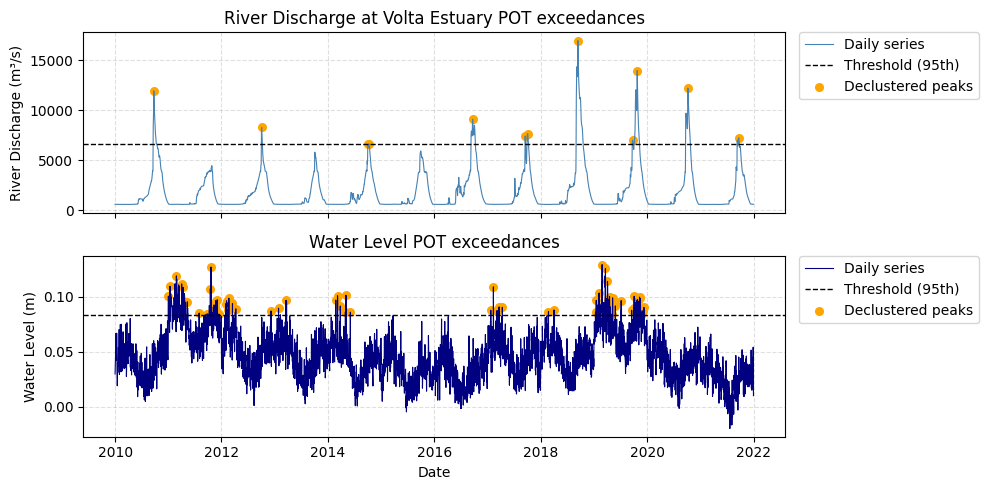

In [55]:
# First try with stationary thresholds 
# Choose high thresholds (test 0.95)
THR_RD  = alignedQW["RD"].quantile(0.95)
THR_WL = alignedQW["WL"].quantile(0.95)
RUNLEN = 3  # days for declustering

def decluster(series, thr, run=3):
    """
    Identify clusters of exceedances and extract one peak per cluster:
    keep one peak per 'event cluster' above threshold.
    Cluster starts when series > thr; cluster ends after 'run' consecutive days below thr.
    Returns Index of peak datetimes and a Series of peak values.
    """
    above = series > thr  # Boolean mask of exceedances
    peaks_idx = []
    i = 0
    while i < len(series):
        if above.iloc[i]:
            # start a cluster at i
            j = i + 1
            below_count = 0 
            while j < len(series):
                if series.iloc[j] > thr:
                    below_count = 0 # still above threshold
                else:
                    below_count += 1
                    if below_count >= run:
                        break   # cluster ends
                j += 1
            cluster = series.iloc[i:j]
            peaks_idx.append(cluster.idxmax())
            i = j
        else:
            i += 1
    peaks_idx = pd.Index(peaks_idx)
    return peaks_idx, series.loc[peaks_idx]

# Find declustered peaks
rd_idx, rd_peaks = decluster(alignedQW["RD"], THR_RD, RUNLEN)
wl_idx, wl_peaks = decluster(alignedQW["WL"], THR_WL, RUNLEN)

years = alignedQW.index.year.nunique()
rate_rd  = len(rd_peaks) / years
rate_wl = len(wl_peaks) / years
print(f"RD peaks: {len(rd_peaks)} ({rate_rd:.2f} events/yr)  |  WL peaks: {len(wl_peaks)} ({rate_wl:.2f} events/yr)")

# Timeline of POT exceedances
fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

# --- River discharge ---
ax[0].plot(alignedQW.index, alignedQW["RD"], lw=0.8, color="steelblue", label="Daily series")
ax[0].axhline(THR_RD, color="k", ls="--", lw=1, label="Threshold (95th)")
ax[0].scatter(rd_peaks.index, rd_peaks.values, s=30, color="orange", label="Declustered peaks")
ax[0].set_ylabel("River Discharge (m³/s)")
ax[0].set_title("River Discharge at Volta Estuary POT exceedances")
ax[0].legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0)

# --- Water level ---
ax[1].plot(alignedQW.index, alignedQW["WL"], lw=0.8, color="navy", label="Daily series")
ax[1].axhline(THR_WL, color="k", ls="--", lw=1, label="Threshold (95th)")
ax[1].scatter(wl_peaks.index, wl_peaks.values, s=30, color="orange", label="Declustered peaks")
ax[1].set_ylabel("Water Level (m)")
ax[1].set_title("Water Level POT exceedances")
ax[1].set_xlabel("Date")
ax[1].legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0)

# Grid & layout
for a in ax:
    a.grid(True, ls="--", alpha=0.4)

plt.tight_layout()
plt.show()



In [56]:
# Pick thresholds (reuse 95th for both)
rd_thr  = THR_RD
wl_thr = THR_WL

# Observed same-day joint exceedances
mask_joint = (alignedQW["RD"] > rd_thr) & (alignedQW["WL"] > wl_thr)
N_joint = int(mask_joint.sum())

# Expected count under independence
pRD  = (alignedQW["RD"] > rd_thr).mean()
pWL = (alignedQW["WL"] > wl_thr).mean()
N   = len(alignedQW)
E_ind = N * pRD * pWL

AF = N_joint / E_ind if E_ind > 0 else np.nan

print(f"Observed joint days: {N_joint}")
print(f"Expected under independence: {E_ind:.1f}")
print(f"Amplification factor AF = {AF:.2f}  (>1 means extra risk from dependence)")


Observed joint days: 15
Expected under independence: 11.0
Amplification factor AF = 1.36  (>1 means extra risk from dependence)


RD peaks: 6 (0.50 events/yr)  |  WL peaks: 41 (3.42 events/yr)


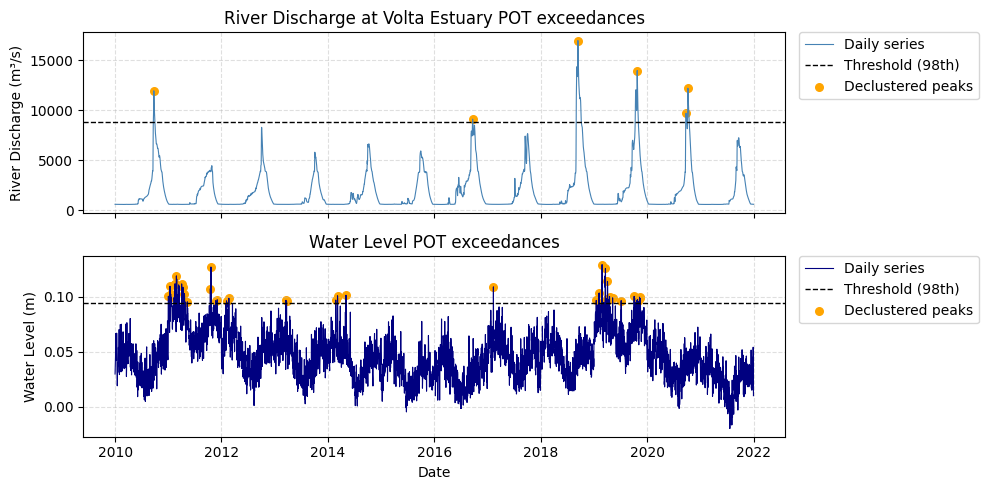

In [57]:
# Choose high thresholds (test 0.98)
THR_RD  = alignedQW["RD"].quantile(0.98)
THR_WL = alignedQW["WL"].quantile(0.98)
RUNLEN = 3  # days for declustering

def decluster(series, thr, run=3):
    """
    Keep one peak per 'event cluster' above threshold.
    Cluster starts when series>thr; cluster ends after 'run' consecutive days below thr.
    Returns Index of peak datetimes and a Series of peak values.
    """
    above = series > thr
    peaks_idx = []
    i = 0
    while i < len(series):
        if above.iloc[i]:
            # start a cluster at i
            j = i + 1
            below_count = 0
            # extend while we haven't seen 'run' consecutive below-thr days
            while j < len(series):
                if series.iloc[j] > thr:
                    below_count = 0
                else:
                    below_count += 1
                    if below_count >= run:
                        break
                j += 1
            cluster = series.iloc[i:j]
            peaks_idx.append(cluster.idxmax())
            i = j
        else:
            i += 1
    peaks_idx = pd.Index(peaks_idx)
    return peaks_idx, series.loc[peaks_idx]

# Find declustered peaks
rd_idx, rd_peaks = decluster(alignedQW["RD"], THR_RD, RUNLEN)
wl_idx, wl_peaks = decluster(alignedQW["WL"], THR_WL, RUNLEN)

years = alignedQW.index.year.nunique()
rate_rd  = len(rd_peaks) / years
rate_wl = len(wl_peaks) / years
print(f"RD peaks: {len(rd_peaks)} ({rate_rd:.2f} events/yr)  |  WL peaks: {len(wl_peaks)} ({rate_wl:.2f} events/yr)")

# Timeline of POT exceedances
fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

# --- River discharge ---
ax[0].plot(alignedQW.index, alignedQW["RD"], lw=0.8, color="steelblue", label="Daily series")
ax[0].axhline(THR_RD, color="k", ls="--", lw=1, label="Threshold (98th)")
ax[0].scatter(rd_peaks.index, rd_peaks.values, s=30, color="orange", label="Declustered peaks")
ax[0].set_ylabel("River Discharge (m³/s)")
ax[0].set_title("River Discharge at Volta Estuary POT exceedances")
ax[0].legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0)

# --- Water level ---
ax[1].plot(alignedQW.index, alignedQW["WL"], lw=0.8, color="navy", label="Daily series")
ax[1].axhline(THR_WL, color="k", ls="--", lw=1, label="Threshold (98th)")
ax[1].scatter(wl_peaks.index, wl_peaks.values, s=30, color="orange", label="Declustered peaks")
ax[1].set_ylabel("Water Level (m)")
ax[1].set_title("Water Level POT exceedances")
ax[1].set_xlabel("Date")
ax[1].legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0)

# Grid & layout
for a in ax:
    a.grid(True, ls="--", alpha=0.4)

plt.tight_layout()
plt.show()



In [58]:
# Pick thresholds (reuse 95th for both)
rd_thr  = THR_RD
wl_thr = THR_WL

# Observed same-day joint exceedances
mask_joint = (alignedQW["RD"] > rd_thr) & (alignedQW["WL"] > wl_thr)
N_joint = int(mask_joint.sum())

# Expected count under independence
pRD  = (alignedQW["RD"] > rd_thr).mean()
pWL = (alignedQW["WL"] > wl_thr).mean()
N   = len(alignedQW)
E_ind = N * pRD * pWL

AF = N_joint / E_ind if E_ind > 0 else np.nan

print(f"Observed joint days: {N_joint}")
print(f"Expected under independence: {E_ind:.1f}")
print(f"Amplification factor AF = {AF:.2f}  (>1 means extra risk from dependence)")


Observed joint days: 3
Expected under independence: 1.7
Amplification factor AF = 1.74  (>1 means extra risk from dependence)


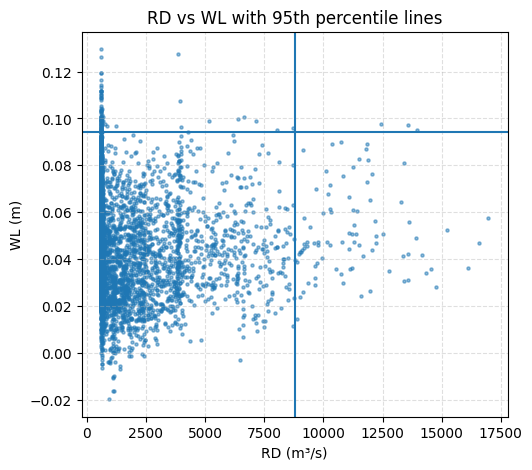

In [59]:
plt.figure(figsize=(5.5,5))
plt.scatter(alignedQW["RD"], alignedQW["WL"], s=5, alpha=0.5)
plt.axvline(rd_thr); plt.axhline(wl_thr)
plt.xlabel("RD (m³/s)"); plt.ylabel("WL (m)")
plt.title("RD vs WL with 95th percentile lines")
plt.grid(True, ls="--", alpha=0.4)
plt.show()


Lag → joint counts: {-5: 5, -4: 4, -3: 4, -2: 4, -1: 3, 0: 3, 1: 4, 2: 4, 3: 4, 4: 4, 5: 4}
Maximum joint count at lag -5 days (RD shifted vs WL) → 5 days


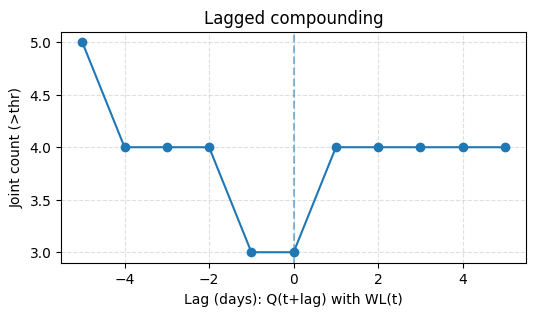

In [60]:
LAGS = range(-5,6)
counts = {}
maskWL = alignedQW["WL"] > wl_thr
for L in LAGS:
    counts[L] = int(((alignedQW["RD"].shift(L) > rd_thr) & maskWL).sum())

best_lag = max(counts, key=counts.get)
print("Lag → joint counts:", counts)
print(f"Maximum joint count at lag {best_lag:+d} days (RD shifted vs WL) → {counts[best_lag]} days")

plt.figure(figsize=(6,3))
plt.plot(list(counts.keys()), list(counts.values()), marker='o')
plt.axvline(0, ls='--', alpha=0.5)
plt.xlabel("Lag (days): Q(t+lag) with WL(t)"); plt.ylabel("Joint count (>thr)")
plt.title("Lagged compounding")
plt.grid(True, ls="--", alpha=0.4)
plt.show()


In [61]:
# Rank -> pseudo-observations U,V in (0,1)
def pseudo_obs(x):
    r = x.rank(method="average")
    return (r - 0.5) / len(r)

U = pseudo_obs(alignedQW["RD"])
V = pseudo_obs(alignedQW["WL"])

def chi_at(u):
    """χ(u) = P(U>u | V>u) estimated empirically."""
    A = ((U > u) & (V > u)).sum()
    B = (V > u).sum()
    return (A / B) if B > 0 else np.nan

taus = alignedQW.corr(method="kendall").loc["RD","WL"]
rhos = alignedQW.corr(method="spearman").loc["RD","WL"]
print(f"Kendall tau:   {taus:.3f}")
print(f"Spearman rho:  {rhos:.3f}")

for u in [0.95, 0.975, 0.99]:
    print(f"chi({u:.3f}) = {chi_at(u):.3f}")


Kendall tau:   -0.140
Spearman rho:  -0.215
chi(0.950) = 0.068
chi(0.975) = 0.037
chi(0.990) = 0.000


In [62]:
def joint_exceed_prob(alignedQW, qthr, wthr):
    m = ((alignedQW["RD"] > qthr) & (alignedQW["WL"] > wthr)).mean()  # fraction of days
    return float(m)

# Evaluate at several percentiles for robustness
quants = [0.95, 0.975, 0.99]
rows = []
for q in quants:
    qthr  = alignedQW["RD"].quantile(q)
    wthr  = alignedQW["WL"].quantile(q)
    pJ = joint_exceed_prob(alignedQW, qthr, wthr)
    T_and_years = (1.0 / pJ) if pJ > 0 else np.inf
    rows.append({"quantile": q, "Q_thr": qthr, "WL_thr": wthr,
                 "P_joint": pJ, "AND_return_period_yrs": T_and_years})
joint_table = pd.DataFrame(rows)
joint_table


,quantile,Q_thr,WL_thr,P_joint,AND_return_period_yrs
0,0.950,6597.639062,0.084000,0.003422,292.20
1,0.975,8303.866797,0.091400,0.000913,1095.75
2,0.990,11125.952813,0.099118,0.000000,inf


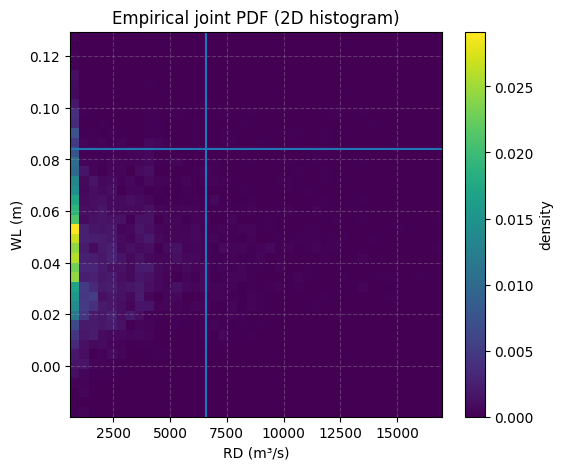

In [63]:
# 2D histogram as empirical joint density (for visualization only)
import numpy as np
H, xedges, yedges = np.histogram2d(alignedQW["RD"].values, alignedQW["WL"].values, bins=40, density=True)
Xc = 0.5*(xedges[:-1] + xedges[1:])
Yc = 0.5*(yedges[:-1] + yedges[1:])

plt.figure(figsize=(6,5))
plt.pcolormesh(xedges, yedges, H.T)   # no explicit colormap to keep it simple
plt.axvline(alignedQW["RD"].quantile(0.95)); plt.axhline(alignedQW["WL"].quantile(0.95))
plt.xlabel("RD (m³/s)"); plt.ylabel("WL (m)")
plt.title("Empirical joint PDF (2D histogram)")
plt.colorbar(label="density")
plt.grid(True, ls="--", alpha=0.3)
plt.show()


(Optional) Quick sensitivity & robustness

Repeat Steps 1B–5 with:

- thresholds = 0.95 / 0.975 / 0.99
- declustering RUNLEN = 3 / 5
- (optional) SEASON_MONTHS = [8,9,10,11]

Add a short paragraph: “Results are qualitatively unchanged across thresholds and run lengths; AF remains >1; lag peak at 0–1 d,” etc.